# Simulation analysis of neutrons from DD source into LZ LXeTPC  

Using BACCARAT with updated GEANT4

## Read-in Data and Basic Stats 

In [3]:
import os
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm

import uproot
import scipy
import awkward as ak

import matplotlib.pyplot as plt
import matplotlib.dates as md
import datetime as dt

In [4]:
#file = '/global/cfs/projectdirs/lz/users/amcadam/BACCARAT-G3-Geant4.11/G4_test_neutrons_root_12345.root' #1000, larger volume 
#file = '/global/cfs/projectdirs/lz/users/amcadam/BACCARAT-G3-Geant4.11/G4_test_neutrons_root_123456.root' #1000
#file = '/global/cfs/projectdirs/lz/users/amcadam/BACCARAT-G3-Geant4.11/G4_test_neutrons_root_1234567.root' #2000
file = '/global/cfs/projectdirs/lz/users/amcadam/BACCARAT-G3-Geant4.11/G4_test_neutrons_root_12345678.root' #4000

In [5]:
content = uproot.open(file)
print(f'Trees inside file: {content.keys()}')

Trees inside file: ['Events;58', 'Events;57', 'RunHeader;1']


In [6]:
runheader = content["RunHeader"].arrays() #run-level information
events = content["Events;58"].arrays() #event information 

In [7]:
#function to list processes by their index (which changes with each file)
def list_processes():
    processID = runheader['runHeader.processIndexes'][0]
    processes = runheader['runHeader.processNames'][0]
    
    for i in range(len(runheader['runHeader.processIndexes'][0])):
        print('Process #{0}: {1}'.format(processID[processID==i][0], processes[processID==i][0]))
    return

In [8]:
list_processes()

Process #0: NoProcess
Process #1: RadioactiveDecay
Process #2: Rayl
Process #3: Transportation
Process #4: compt
Process #5: eBrem
Process #6: eIoni
Process #7: hadElastic
Process #8: ionIoni
Process #9: msc
Process #10: nCapture
Process #11: neutronInelastic
Process #12: phot
Process #13: annihil
Process #14: conv


In [9]:
print(f'Number of events: {len(events["header.eventId"])}')

Number of events: 4000


In [10]:
#function to find a processid given a process name 
def find_processes(name):
    processID = runheader['runHeader.processIndexes'][0]
    processes = runheader['runHeader.processNames'][0]
    
    for i in range(len(runheader['runHeader.processIndexes'][0])):
        if processes[i] == name:
            return processID[i]
        

In [11]:
neutronInelasticId = find_processes('neutronInelastic')

In [12]:
#looking at numbers
neutrons_xenon_events = np.array([], dtype=int) #list of eventIds with at least 1 neutron 
num_inelastic_scatter = 0
inelastic_events = np.array([], dtype=int) #list of eventIds where there is a neutronInelastic process 

for i_evt in events['header.eventId']:

    if events[i_evt]['volume.names'].tolist() != []: #particles reach xenon 

        for i_particle, particle in enumerate(events[i_evt]['track.particleNames']):
            if particle == 'neutron':
                neutrons_xenon_events = np.append(neutrons_xenon_events, i_evt)
                
                if events[i_evt]['track.step.processesID'][i_particle][-1] == neutronInelasticId: 
                    inelastic_events = np.append(inelastic_events, i_evt)
                    num_inelastic_scatter +=1

neutrons_xenon_events = np.unique(neutrons_xenon_events)
num_neutrons_xenon = len(neutrons_xenon_events)  

inelastic_events = np.unique(inelastic_events) 

print(f'Events where neutron reached Xenon: {num_neutrons_xenon}/{len(events["header.eventId"])}')
print(f'Number of events with at least one inelastic neutron scatter: {len(inelastic_events)}')
print(f'Total number of inelastic neutron scatters: {num_inelastic_scatter}') 


Events where neutron reached Xenon: 4000/4000
Number of events with at least one inelastic neutron scatter: 3015
Total number of inelastic neutron scatters: 5653


In [128]:
len(events[800]["track.particleIDs"])

966

## Kinetic Energies of Gammas Produced in Xenon De-excitation

In [ ]:
event_names = events[inelastic_events]["track.particleNames"]
event_processes = events[inelastic_events]["track.particleCreatorProcesses"]

In [ ]:
#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
gammas_energy = []

for x in range(len(event_names)):
    for i in range(len(event_names[x])):
        if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
            gammas_energy.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 
            

In [ ]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 100, histtype='step', color='black')
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));


In [ ]:
#look at which Xenon isotopes neutrons interacted with 

particles = []
for i_evt in inelastic_events:
    #look at neutron inelastic particles only 
    #print(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'neutronInelastic'])
    particles.append(np.array(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'neutronInelastic']))
    
isotopes = []
for particle_array in particles:
    for p in particle_array:
        if p.startswith('Xe'):
            isotopes.append(p)
            
isotopes, counts = np.unique(np.array(isotopes), return_counts=True)

print('Neutrons inelastically scattered from these Xenon isotopes:')
for i in range(len(isotopes)):
    print(f'{isotopes[i]} {counts[i]} occurances') 

    
#Xenon counted matches number of inelastic scatters!
print()
print(f'Number of neutron inelastic scatters: {num_inelastic_scatter}')
print(f'Xenon atoms counted: {np.sum(counts)}') 
print(f'Gammas counted: {len(gammas_energy)}')

In [ ]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 100, histtype='step', color='black')

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));


#plot lines to compare to literature 

#Xe129 

plt.axvline(39.5774, color='red', alpha=0.5, label='Xe129') #3/2+ -> 1/2+ #most prominent 
plt.axvline(38.1, color='red', alpha=0.5)
plt.axvline(196.56, color='red', alpha=0.5) #11/2- -> 3/2+
plt.axvline(318.18, color='red', alpha=0.5) #3/2+ -> 1/2+
plt.axvline(321.7, color='red', alpha=0.5) #5/2+ -> 1/2+
plt.axvline(479.1, color='red', alpha=0.5) #7/2+ -> 3/2+
plt.axvline(402.6, color='red', alpha=0.5) #5/2+ -> 3/2+




#Xe131  
plt.axvline(80.1854, color='green', alpha=0.5, label='Xe131') #most prominent  
plt.axvline(163.93, color='green', alpha=0.5)
plt.axvline(364.489, color='green', alpha=0.5)
plt.axvline(404.814, color='green', alpha=0.5)



#Xe132 
plt.axvline(173.6, color='cyan', alpha=0.5)
plt.axvline(538.1, color='cyan', alpha=0.5, label='Xe132')
plt.axvline(667.75, color='cyan', alpha=0.5)
plt.axvline(772.6, color='cyan', alpha=0.5)


    
#Xe130 
plt.axvline(536.066, color='magenta', alpha=0.5, label='Xe130', ) 
plt.axvline(586.049, color='magenta', alpha=0.5) 
plt.axvline(668.536, color='magenta', alpha=0.5) 

#Xe134
plt.axvline(847.025, color='yellow', alpha=0.5, label='Xe134')

#Xe136
plt.axvline(1313.02, color='blue', alpha=0.5, label='Xe136') 

#Xe124 

#Xe128 

plt.legend()



### Inspecting Rare Gammas

##### Looking at small peaks ~70keV

(0.0, 100.0)

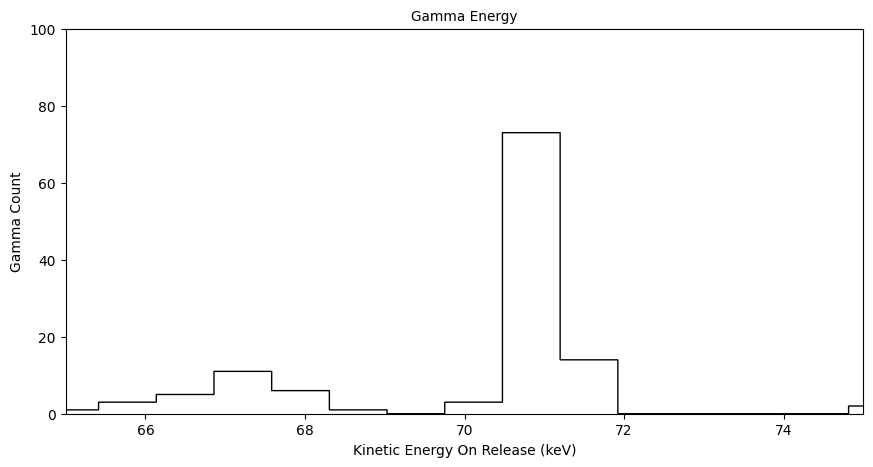

In [337]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(65, 75)
plt.ylim(0, 100)



In [376]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>65 and item<75]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec, 1), return_counts=True)

In [377]:
print(energies)
print(counts)

[65.8 65.9 66.2 66.3 66.5 66.6 67.  67.1 67.3 67.4 67.6 67.7 69.  69.8
 70.2 70.6 70.7 70.8 70.9 71.  71.1 71.2 71.3 71.4 71.5 71.8 71.9]
[ 2  1  2  1  1  1  2  3  2  2  4  4  1  1  2  2  6 14 10 29 10  6  2  4
  2  1  1]


Not sure about this peak

##### Looking at small peaks 400-420keV

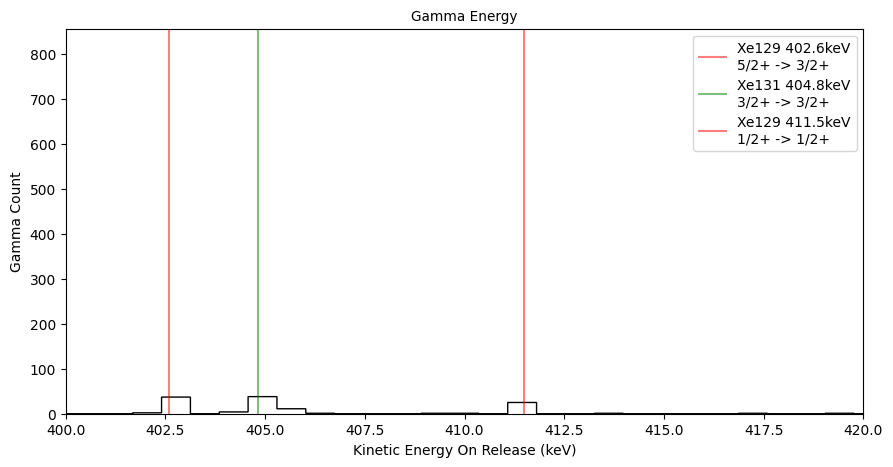

In [340]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(400, 420)
#plt.ylim(0, 30)

plt.axvline(402.6, color='red', alpha=0.5, label='Xe129 402.6keV' + '\n' + '5/2+ -> 3/2+') 
plt.axvline(404.814, color='green', alpha=0.5, label='Xe131 404.8keV'+ '\n' + '3/2+ -> 3/2+')
plt.axvline(411.490, color='red', alpha=0.5, label='Xe129 411.5keV' + '\n' + '1/2+ -> 1/2+') 

plt.legend()


In [341]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>400 and item<420]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [342]:
print(energies)
print(counts)

[401.74 402.27 402.6  404.35 404.55 404.57 404.58 404.59 404.65 404.66
 404.67 404.69 404.71 404.72 404.76 404.77 404.78 404.79 404.8  404.81
 405.36 405.45 405.6  406.13 409.5  410.09 411.23 411.24 411.28 411.3
 411.38 411.39 411.41 411.42 411.43 411.46 411.47 411.48 411.49 413.96
 417.19 419.35]
[ 1  1 37  1  1  2  1  2  1  1  2  1  2  1  1  2  1  1  2 20  1  9  1  1
  1  1  1  1  1  1  2  1  1  1  1  2  2  1 10  1  1  1]


##### Looking at small peak 2160-2180keV

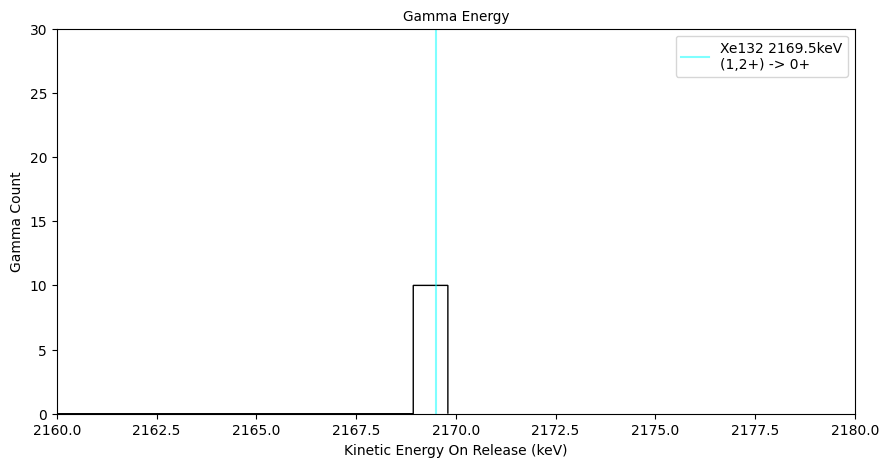

In [343]:

plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(2160, 2180)
plt.ylim(0, 30)


plt.axvline(2169.5, color='cyan', alpha=0.5, label='Xe132 2169.5keV' + '\n' + '(1,2+) -> 0+')
plt.legend()


In [344]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>2160 and item<2180]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [345]:
energies, counts

(array([2169.8]), array([10]))

##### Looking at small peaks 280-300keV

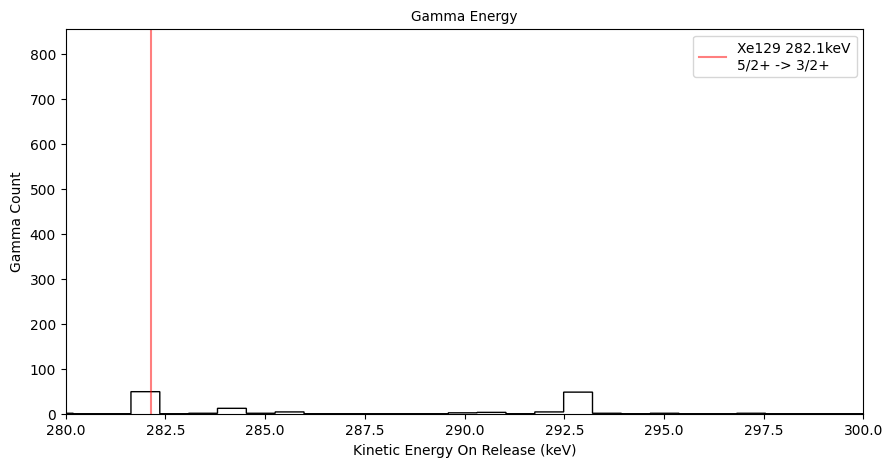

In [346]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(280, 300)
#plt.ylim(0, 50)

plt.axvline(282.131, color='red', alpha=0.5, label='Xe129 282.1keV' + '\n' + '5/2+ -> 3/2+') 

plt.legend()


In [347]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item>280 and item<300]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec,2), return_counts=True)

In [348]:
energies, counts

(array([281.74, 282.13, 283.46, 284.05, 284.21, 284.24, 284.29, 284.3 ,
        285.21, 285.36, 285.55, 290.25, 290.49, 290.87, 292.43, 292.45,
        292.53, 292.55, 292.59, 292.6 , 292.61, 292.62, 292.68, 292.7 ,
        292.71, 292.74, 292.76, 292.8 , 292.88, 292.91, 292.97, 293.89,
        295.09, 297.46]),
 array([ 1, 48,  1,  1,  1,  1,  1,  8,  1,  2,  2,  2,  2,  1,  2,  2,  2,
         4,  4,  2,  2,  2,  4,  4,  6,  2,  4,  4,  2,  2,  4,  1,  1,  1]))

Can't find the 292 peak??

##### Xe124 Lowest Excitation Energy Peak

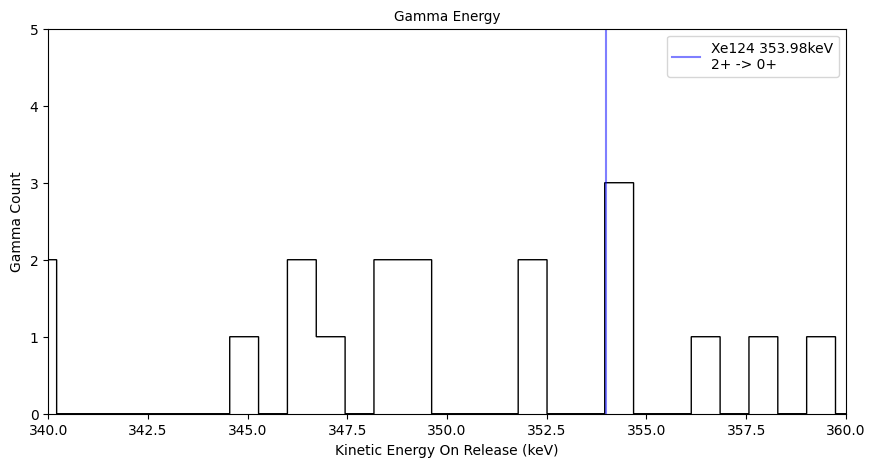

In [375]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(340, 360)
plt.ylim(0, 5)

plt.axvline(353.98, color='blue', alpha=0.5, label='Xe124 353.98keV'+ '\n' + '2+ -> 0+')
plt.legend()


##### Gammas <40keV

(0.0, 35.0)

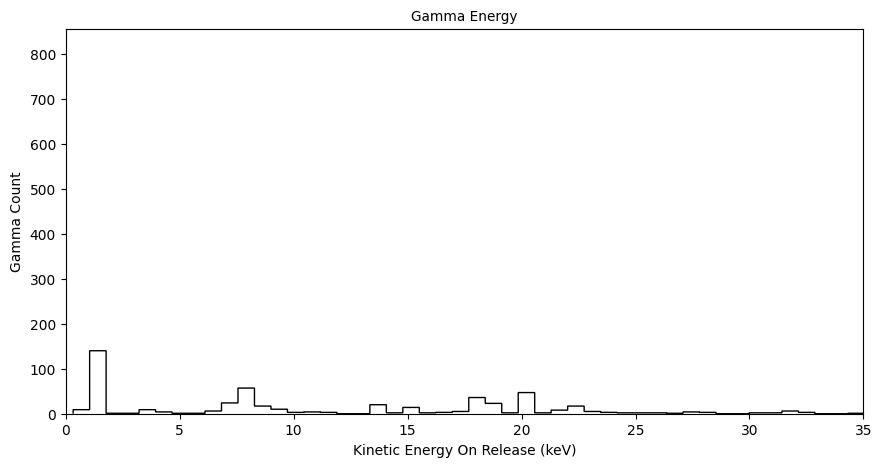

In [350]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 3000, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(0, 35)
#plt.ylim(0, 75)


In [351]:
#use to look a specific energy values for given range  
gammas_energy_spec = [item for item in gammas_energy if item<35]
np.sort(gammas_energy_spec)
energies, counts = np.unique(np.round(gammas_energy_spec), return_counts=True)

In [352]:
energies, counts

(array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
        26., 27., 28., 29., 30., 31., 32., 35.]),
 array([ 1, 83, 66,  2, 11,  2,  3, 20, 66, 25,  4,  6,  1,  2, 19, 13,  6,
         4, 44, 19, 47,  2, 25,  5,  5,  2,  2,  3,  4,  1,  2,  3,  8,  1]))

Still not sure cause of very low energy gammas 

Much fewer low energy gammas then previous gamma energy plot - selecting 2.45MeV neutrons helped filter

## Kinetic Energies of Gammas Sorted By Xenon Isotope 

Gammas will definitely be added to more than one list if using previous code -> changed so only look at single scatters, should be accurate, faster since can use elifs and less events -> need lots of events

In [13]:
event_names = events[inelastic_events]["track.particleNames"]
event_processes = events[inelastic_events]["track.particleCreatorProcesses"]

In [138]:
#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
#single scatter sorting, slow and not much data for sims with low events 

"""
gammas_energies_xe124 = []
gammas_energies_xe126 = []
gammas_energies_xe128 = []
gammas_energies_xe129 = []
gammas_energies_xe130 = []
gammas_energies_xe131 = []
gammas_energies_xe132 = []
gammas_energies_xe134 = []
gammas_energies_xe136 = []

for x in range(len(event_names)):
    
    counter = 0
    for n in event_names[x]:
        if n.startswith('Xe'):
            counter+=1
          
    #only single inelastic scatters 
    if counter==1:
    
        if 'Xe124' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe124.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe126' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe126.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe128' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe128.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe129' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe129.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe130' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe130.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe131' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe131.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe132' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe132.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe134' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe134.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

        elif 'Xe136' in event_names[x]:
            for i in range(len(event_names[x])):
                if event_names[x][i] == 'gamma' and event_processes[x][i] == 'neutronInelastic':
                    gammas_energies_xe136.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies 

"""

'\ngammas_energies_xe124 = []\ngammas_energies_xe126 = []\ngammas_energies_xe128 = []\ngammas_energies_xe129 = []\ngammas_energies_xe130 = []\ngammas_energies_xe131 = []\ngammas_energies_xe132 = []\ngammas_energies_xe134 = []\ngammas_energies_xe136 = []\n\nfor x in range(len(event_names)):\n    \n    counter = 0\n    for n in event_names[x]:\n        if n.startswith(\'Xe\'):\n            counter+=1\n          \n    #only single inelastic scatters \n    if counter==1:\n    \n        if \'Xe124\' in event_names[x]:\n            for i in range(len(event_names[x])):\n                if event_names[x][i] == \'gamma\' and event_processes[x][i] == \'neutronInelastic\':\n                    gammas_energies_xe124.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0]) #first step gamma kinetic energies \n\n        elif \'Xe126\' in event_names[x]:\n            for i in range(len(event_names[x])):\n                if event_names[x][i] == \'gamma\' and event_processes[x][i] == \'n

In [14]:
#alternate sorting -> trying to get around single scatter categorising using parentid -> seems to work? check

#find the kinetic energies of gammas released by de-excitation of xenon nuclei to compare to literature
gammas_energies_xe124 = []
gammas_energies_xe126 = []
gammas_energies_xe128 = []
gammas_energies_xe129 = []
gammas_energies_xe130 = []
gammas_energies_xe131 = []
gammas_energies_xe132 = []
gammas_energies_xe134 = []
gammas_energies_xe136 = []

for x in range(len(event_names)):

    for i_l1, name_l1 in enumerate(event_names[x]):
        xenon_iso = ''
        if name_l1.startswith('Xe') and event_processes[x][i_l1]=='neutronInelastic':
            parent=events[inelastic_events]["track.particleParentIDs"][x][i_l1]
            xenon_iso = name_l1
        
            for i, name in enumerate(event_names[x]):  

                if name=='gamma' and event_processes[x][i]=='neutronInelastic' and events[inelastic_events]["track.particleParentIDs"][x][i]==parent:

                    if xenon_iso == 'Xe129':
                        gammas_energies_xe129.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe131':
                        gammas_energies_xe131.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe132':
                        gammas_energies_xe132.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe124':
                        gammas_energies_xe124.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe126':
                        gammas_energies_xe126.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe128':
                        gammas_energies_xe128.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe130':
                        gammas_energies_xe130.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe134':
                        gammas_energies_xe134.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])

                    elif xenon_iso == 'Xe136':
                        gammas_energies_xe136.append(events[inelastic_events]["track.step.kinEnergies_keV"][x][i][0])



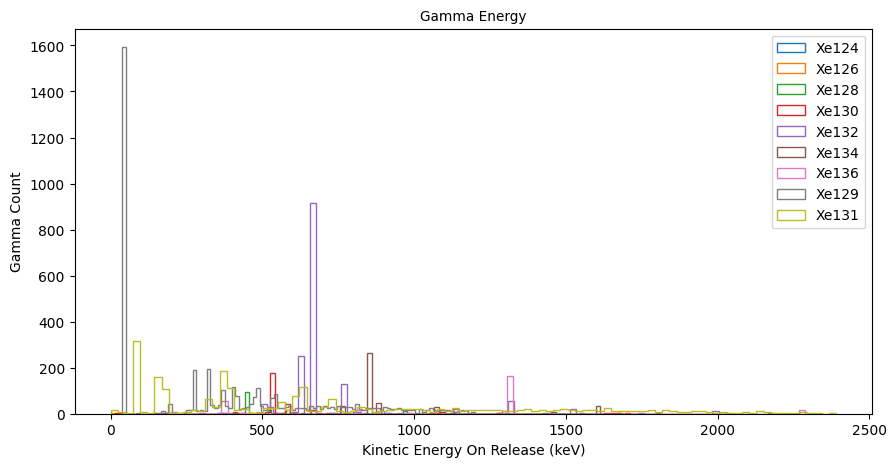

In [15]:
plt.figure(figsize=(35, 5));
plt.subplot(131);

plt.hist(gammas_energies_xe124, 100, histtype='step', label='Xe124')
plt.hist(gammas_energies_xe126, 100, histtype='step', label='Xe126')
plt.hist(gammas_energies_xe128, 100, histtype='step', label='Xe128')
plt.hist(gammas_energies_xe130, 100, histtype='step', label='Xe130')
plt.hist(gammas_energies_xe132, 100, histtype='step', label='Xe132')
plt.hist(gammas_energies_xe134, 100, histtype='step', label='Xe134')
plt.hist(gammas_energies_xe136, 100, histtype='step', label='Xe136')
plt.hist(gammas_energies_xe129, 100, histtype='step', label='Xe129')
plt.hist(gammas_energies_xe131, 100, histtype='step', label='Xe131')


plt.legend()
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));




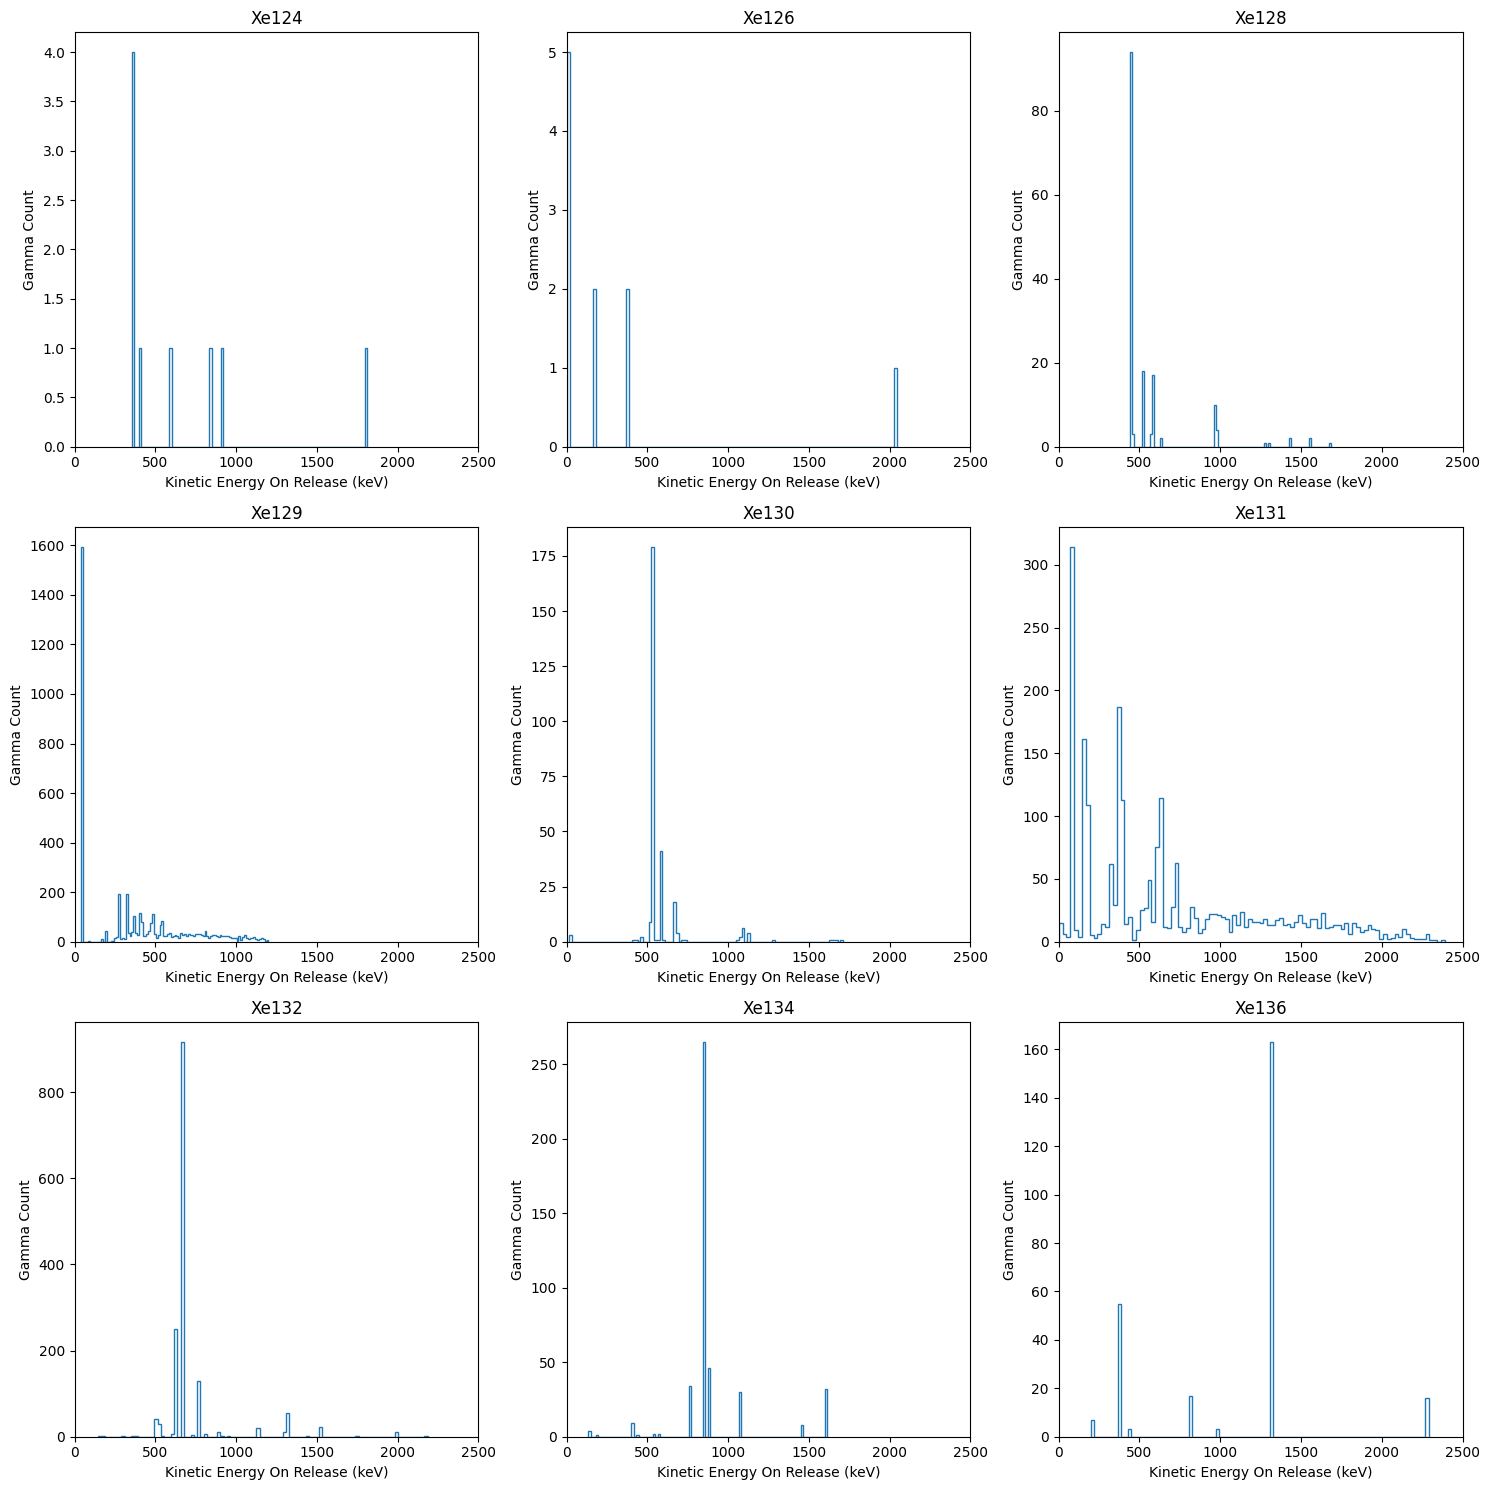

In [16]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot histograms in each subplot
axes[0].hist(gammas_energies_xe124, 100, histtype='step')
axes[0].set_title('Xe124')
axes[1].hist(gammas_energies_xe126, 100, histtype='step')
axes[1].set_title('Xe126')
axes[2].hist(gammas_energies_xe128, 100, histtype='step')
axes[2].set_title('Xe128')
axes[3].hist(gammas_energies_xe129, 100, histtype='step')
axes[3].set_title('Xe129')
axes[4].hist(gammas_energies_xe130, 100, histtype='step')
axes[4].set_title('Xe130')
axes[5].hist(gammas_energies_xe131, 100, histtype='step')
axes[5].set_title('Xe131')
axes[6].hist(gammas_energies_xe132, 100, histtype='step')
axes[6].set_title('Xe132')
axes[7].hist(gammas_energies_xe134, 100, histtype='step')
axes[7].set_title('Xe134')
axes[8].hist(gammas_energies_xe136, 100, histtype='step')
axes[8].set_title('Xe136')

for i in range(9):
    axes[i].set_xlabel('Kinetic Energy On Release (keV)')  # Add x-axis label
    axes[i].set_ylabel('Gamma Count')  # Add y-axis label
    axes[i].set_xlim(0, 2500)  # Set x-axis limits
    axes[i].set_ylim(0,)  # Set y-axis limits
    
    
# Adjust the layout
plt.tight_layout()
plt.show()

Checking lower energies

(0.0, 35.0)

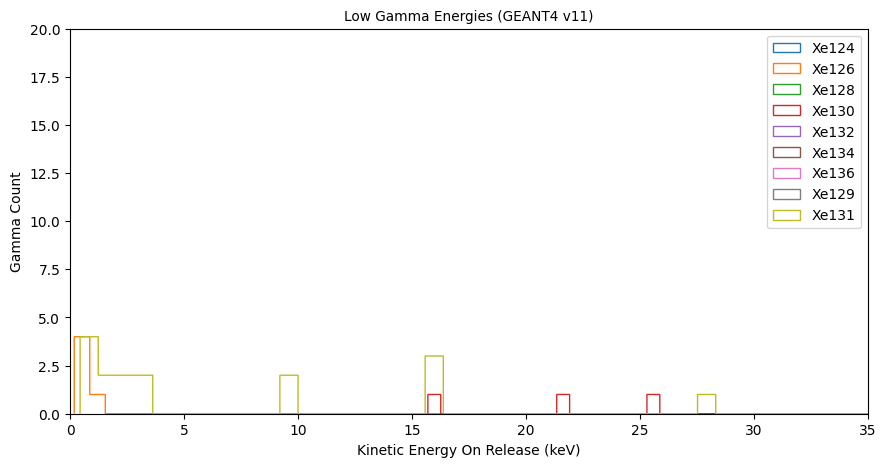

In [21]:
plt.figure(figsize=(35, 5));
plt.subplot(131);

plt.hist(gammas_energies_xe124, 3000, histtype='step', label='Xe124')
plt.hist(gammas_energies_xe126, 3000, histtype='step', label='Xe126')
plt.hist(gammas_energies_xe128, 3000, histtype='step', label='Xe128')

plt.hist(gammas_energies_xe130, 3000, histtype='step', label='Xe130')

plt.hist(gammas_energies_xe132, 3000, histtype='step', label='Xe132')
plt.hist(gammas_energies_xe134, 3000, histtype='step', label='Xe134')
plt.hist(gammas_energies_xe136, 3000, histtype='step', label='Xe136')

plt.hist(gammas_energies_xe129, 3000, histtype='step', label='Xe129')
plt.hist(gammas_energies_xe131, 3000, histtype='step', label='Xe131')


plt.legend()
plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Low Gamma Energies (GEANT4 v11)', fontsize=(9.8));
plt.ylim(0,20)
plt.xlim(0,35)


## Check Gamma Lines By Isotope

In [296]:
#read in literature xenon data

# Directory containing the CSV files
directory = '/global/cfs/projectdirs/lz/users/amcadam/xenon_data'

# Initialize an empty dictionary to store DataFrames
dfs = {}

# Loop through the files in the directory
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        # Construct full file path
        file_path = os.path.join(directory, filename)
        
        # Read the CSV file into a DataFrame
        df = pd.read_csv(file_path)
        
        # Store the DataFrame in the dictionary
        dfs[filename] = df

# Access a specific DataFrame
print(dfs['xe129.csv'].keys())

# get gammas energies
print(np.round(dfs['xe129.csv'][' energy [keV]'][:10]))

Index(['Z', 'N', 'symbol', 'start level #', 'start level energy [keV]', ' unc',
       ' start level jp', 'final level #', 'final level energy [keV]',
       ' unc.1', 'final level jp', ' idx', ' energy [keV]', ' unc.2',
       ' relative intensity ', ' unc.3', ' multipolarity', ' mixing ratio',
       ' unc.4', ' B(E1)', ' B(E1) unc', ' B(E2)', ' B(E2) unc', ' B(M1)',
       ' B(M1) unc', ' B(M2)', ' B(M2) unc', 'tot conv coeff', 'unc',
       'ENSDF_publication_cut-off', 'ENSDF_authors', 'Extraction_date'],
      dtype='object')
0     40.0
1    197.0
2     38.0
3    279.0
4    318.0
5    282.0
6    322.0
7     90.0
8     93.0
9    372.0
Name:  energy [keV], dtype: float64


##### Xe129

Rounded the gammas energies to whole numbers, not sure if sim is meant to produce exact and to what s.f.

In [297]:
sim_lines129, counts129 = np.unique(np.round(gammas_energies_xe129), return_counts=True)

Anything lower than 38 is unphysical for xe129

In [298]:
#round energies whole number to compare sim to literature
all_lines129 = [] #distinct possible potential gamma energies 
for line in np.unique(np.round(np.array(dfs['xe129.csv'][' energy [keV]']))): #when you round energies some lines get rounded to same value
    if line<=2450: #max energy from inelastic scatter 
        all_lines129.append(line)
        
#find real and fake lines 
real129 = []
fake129 = []
for line in sim_lines129:
    if line in all_lines129:
        real129.append(line)
    else:
        fake129.append(line)
        
missing129 = []
for line in all_lines129:
    if line not in sim_lines129:
        missing129.append(line) 
   

print(f'{len(all_lines129)} possible real lines from ENSDF')        
print(f'There are {len(real129)} real lines in sim')

print(f'There are {len(missing129)} missing real lines in sim')
#print(f'There are {len(all_lines129)-len(real129)} missing real lines') #why are these not the same, multipliticty of lines causing confusion - change to distinct lines 

print(f'There are {len(fake129)} fake lines in sim')

112 possible real lines from ENSDF
There are 65 real lines in sim
There are 47 missing real lines in sim
There are 520 fake lines in sim


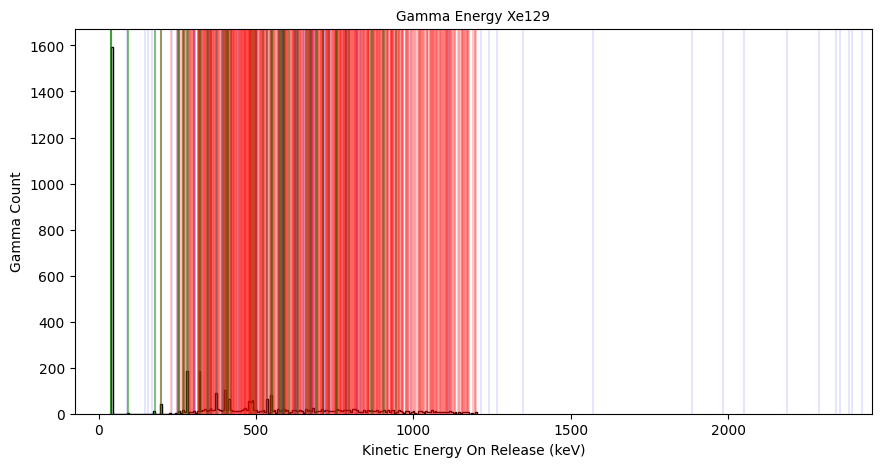

In [299]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energies_xe129, 200, histtype='step', color='black')

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy Xe129', fontsize=(9.8));

for line in real129:    
    plt.axvline(line, color='green', alpha=0.5) 

for line in fake129:
    plt.axvline(line, color='red', alpha=0.2) 
    
for line in missing129:
    plt.axvline(line, color='blue', alpha=0.1) 



Green shows real lines, blue shows missing real lines, red shows fake lines

##### Xe131

In [300]:
sim_lines131, counts131 = np.unique(np.round(gammas_energies_xe131), return_counts=True)

In [301]:
#round energies whole number and compare sim to literature
all_lines131 = [] #distinct possible potential gamma energies 
for line in np.unique(np.round(np.array(dfs['xe131.csv'][' energy [keV]']))): #when you round energies some lines get rounded to same value
    if line<=2450: #max energy from inelastic scatter 
        all_lines131.append(line)
        
#find real and fake lines 
real131 = []
fake131 = []
for line in sim_lines131:
    if line in all_lines131:
        real131.append(line)
    else:
        fake131.append(line)
        
missing131 = []
for line in all_lines131:
    if line not in sim_lines131:
        missing131.append(line) 
   

print(f'{len(all_lines131)} possible real lines from ENSDF')        
print(f'There are {len(real131)} real lines in sim')
print(f'There are {len(missing131)} missing real lines in sim')
print(f'There are {len(fake131)} fake lines in sim')

66 possible real lines from ENSDF
There are 46 real lines in sim
There are 20 missing real lines in sim
There are 727 fake lines in sim


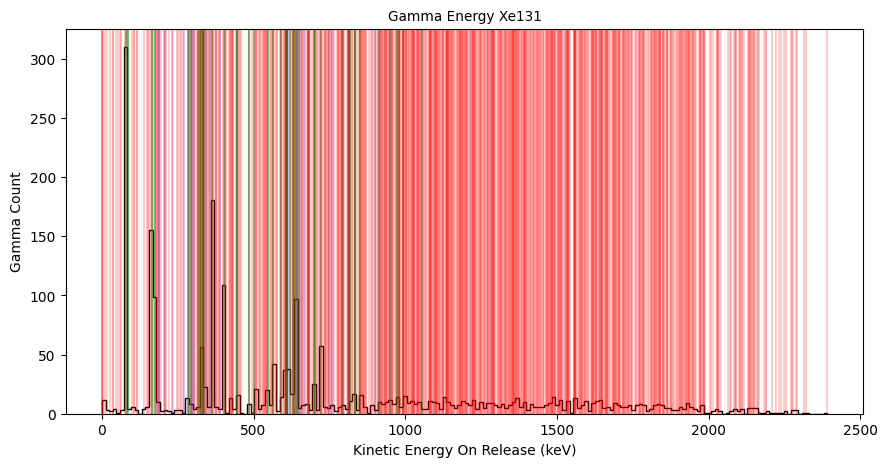

In [309]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energies_xe131, 200, histtype='step', color='black')

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy Xe131', fontsize=(9.8));

for line in real131:    
    plt.axvline(line, color='green', alpha=0.5) 

for line in missing131:
    plt.axvline(line, color='blue', alpha=0.2) 

for line in fake131:
    plt.axvline(line, color='red', alpha=0.2) 
    
#plt.axvline(164, color='yellow', alpha=1, label='236')    


A lot of fake lines 

Xe132

In [303]:
sim_lines132, counts132 = np.unique(np.round(gammas_energies_xe132), return_counts=True)

In [326]:
#round energies whole number to compare sim to literature
all_lines132 = [] #distinct possible potential gamma energies 
for line in np.unique(np.round(np.array(dfs['xe132.csv'][' energy [keV]']))): #when you round energies some lines get rounded to same value
    if line<=2450: #max energy from inelastic scatter 
        all_lines132.append(line)
        
#find real and fake lines 
real132 = []
fake132 = []
for line in sim_lines132:
    if line in all_lines132:
        real132.append(line)
    else:
        fake132.append(line)
        
missing132 = []
for line in all_lines132:
    if line not in sim_lines132:
        missing132.append(line) 

#check if fake lines are within 1keV of real lines 
real132_th=[]
for line in fake132:
    if line+1 in sim_lines132 or line-1 in sim_lines132:
        real132_th.append(line)
        
fake132_th = list(set(fake132).symmetric_difference(set(real132_th)))  

print(f'{len(all_lines132)} possible real lines from ENSDF')        
print(f'There are {len(real132)} real lines in sim')
print(f'There are {len(missing132)} missing real lines in sim')
print(f'There are {len(fake132)} fake lines in sim')

print('')
print(f'There are {len(set(fake132).symmetric_difference(set(real132_th)))} fake lines assuming lines within 1keV of real line are real')

163 possible real lines from ENSDF
There are 27 real lines in sim
There are 136 missing real lines in sim
There are 13 fake lines in sim

There are 2 fake lines assuming lines within 1keV of real line are real


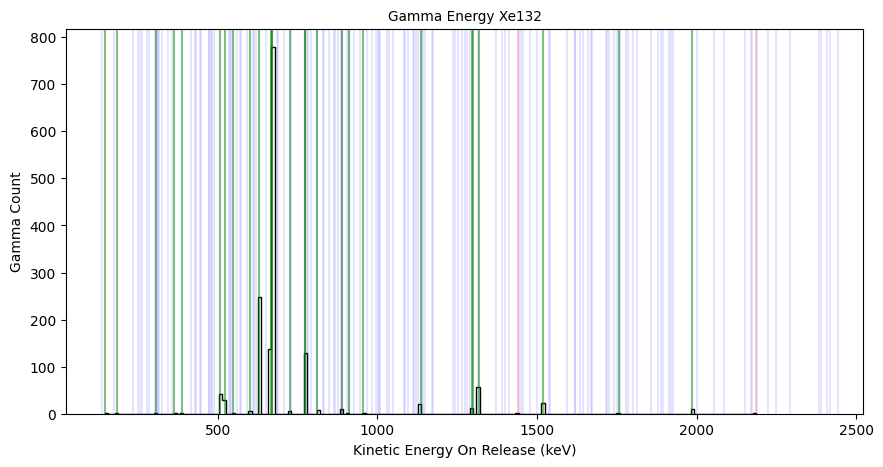

In [327]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energies_xe132, 200, histtype='step', color='black')

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy Xe132', fontsize=(9.8));

for line in real132:    
    plt.axvline(line, color='green', alpha=0.5) 

for line in missing132:
    plt.axvline(line, color='blue', alpha=0.1) 

for line in fake132_th:
    plt.axvline(line, color='red', alpha=0.2) 


Using ±1keV reduces fake gammas 

In [347]:
#look at all isotopes to get lists or real and fake lines for each one 
#loop through dataframes 
gamma_data = {}

for key in list(dfs.keys()):
    lit_data_gammas = dfs[key][' energy [keV]']
    sim_data_gammas_name = f"gammas_energies_{key[:5]}"
    sim_data_gammas = globals().get(sim_data_gammas_name)
    
    sim_lines, counts = np.unique(np.round(sim_data_gammas), return_counts=True)
    
    
    #round energies whole number and compare sim to literature
    all_lines = [] #distinct possible potential gamma energies 
    for line in np.unique(np.round(np.array(lit_data_gammas))): #when you round energies some lines get rounded to same value
        if line<=2450: #max energy from inelastic scatter 
            all_lines.append(line)
            
    real = []
    fake = []
    for line in sim_lines:
        if line in all_lines:
            real.append(line)
        else:
            fake.append(line)
            
            
    missing = []
    for line in all_lines:
        if line not in sim_lines:
            missing.append(line) 

    #check if fake lines are within 1keV of real lines 
    real_th=[]
    for line in fake:
        if line+1 in sim_lines or line-1 in sim_lines:
        #if line+1 in sim_lines or line-1 in sim_lines or line+2 in sim_lines or line-2 in sim_lines:
        
            real_th.append(line)

    fake_th = list(set(fake).symmetric_difference(set(real_th))) 

    
    data = {'real': real, 'fake': fake, 'missing': missing, 'fake_th': fake_th}
        
    gamma_data[key[:5]] = data #dictionary of dictionaries 
    
    print(f'For {key[:5]}')
    print(f'{len(all_lines)} possible real lines from ENSDF (rounded to integer, <2450keV)')        
    print(f'There are {len(real)} real lines in sim')
    print(f'There are {len(missing)} missing real lines in sim')
    print(f'There are {len(fake)} fake lines in sim')
    print(f'There are {len(fake_th)} fake lines outside of 1keV of real line')  
    #print(f'There are {len(fake_th)} fake lines outside of 2keV of real line')    
    
    print('')


For xe129
112 possible real lines from ENSDF (rounded to integer, <2450keV)
There are 65 real lines in sim
There are 47 missing real lines in sim
There are 520 fake lines in sim
There are 88 fake lines outside of 1keV of real line

For xe130
174 possible real lines from ENSDF (rounded to integer, <2450keV)
There are 13 real lines in sim
There are 161 missing real lines in sim
There are 20 fake lines in sim
There are 14 fake lines outside of 1keV of real line

For xe124
352 possible real lines from ENSDF (rounded to integer, <2450keV)
There are 5 real lines in sim
There are 347 missing real lines in sim
There are 1 fake lines in sim
There are 1 fake lines outside of 1keV of real line

For xe132
163 possible real lines from ENSDF (rounded to integer, <2450keV)
There are 27 real lines in sim
There are 136 missing real lines in sim
There are 13 fake lines in sim
There are 2 fake lines outside of 1keV of real line

For xe131
66 possible real lines from ENSDF (rounded to integer, <2450keV)
T

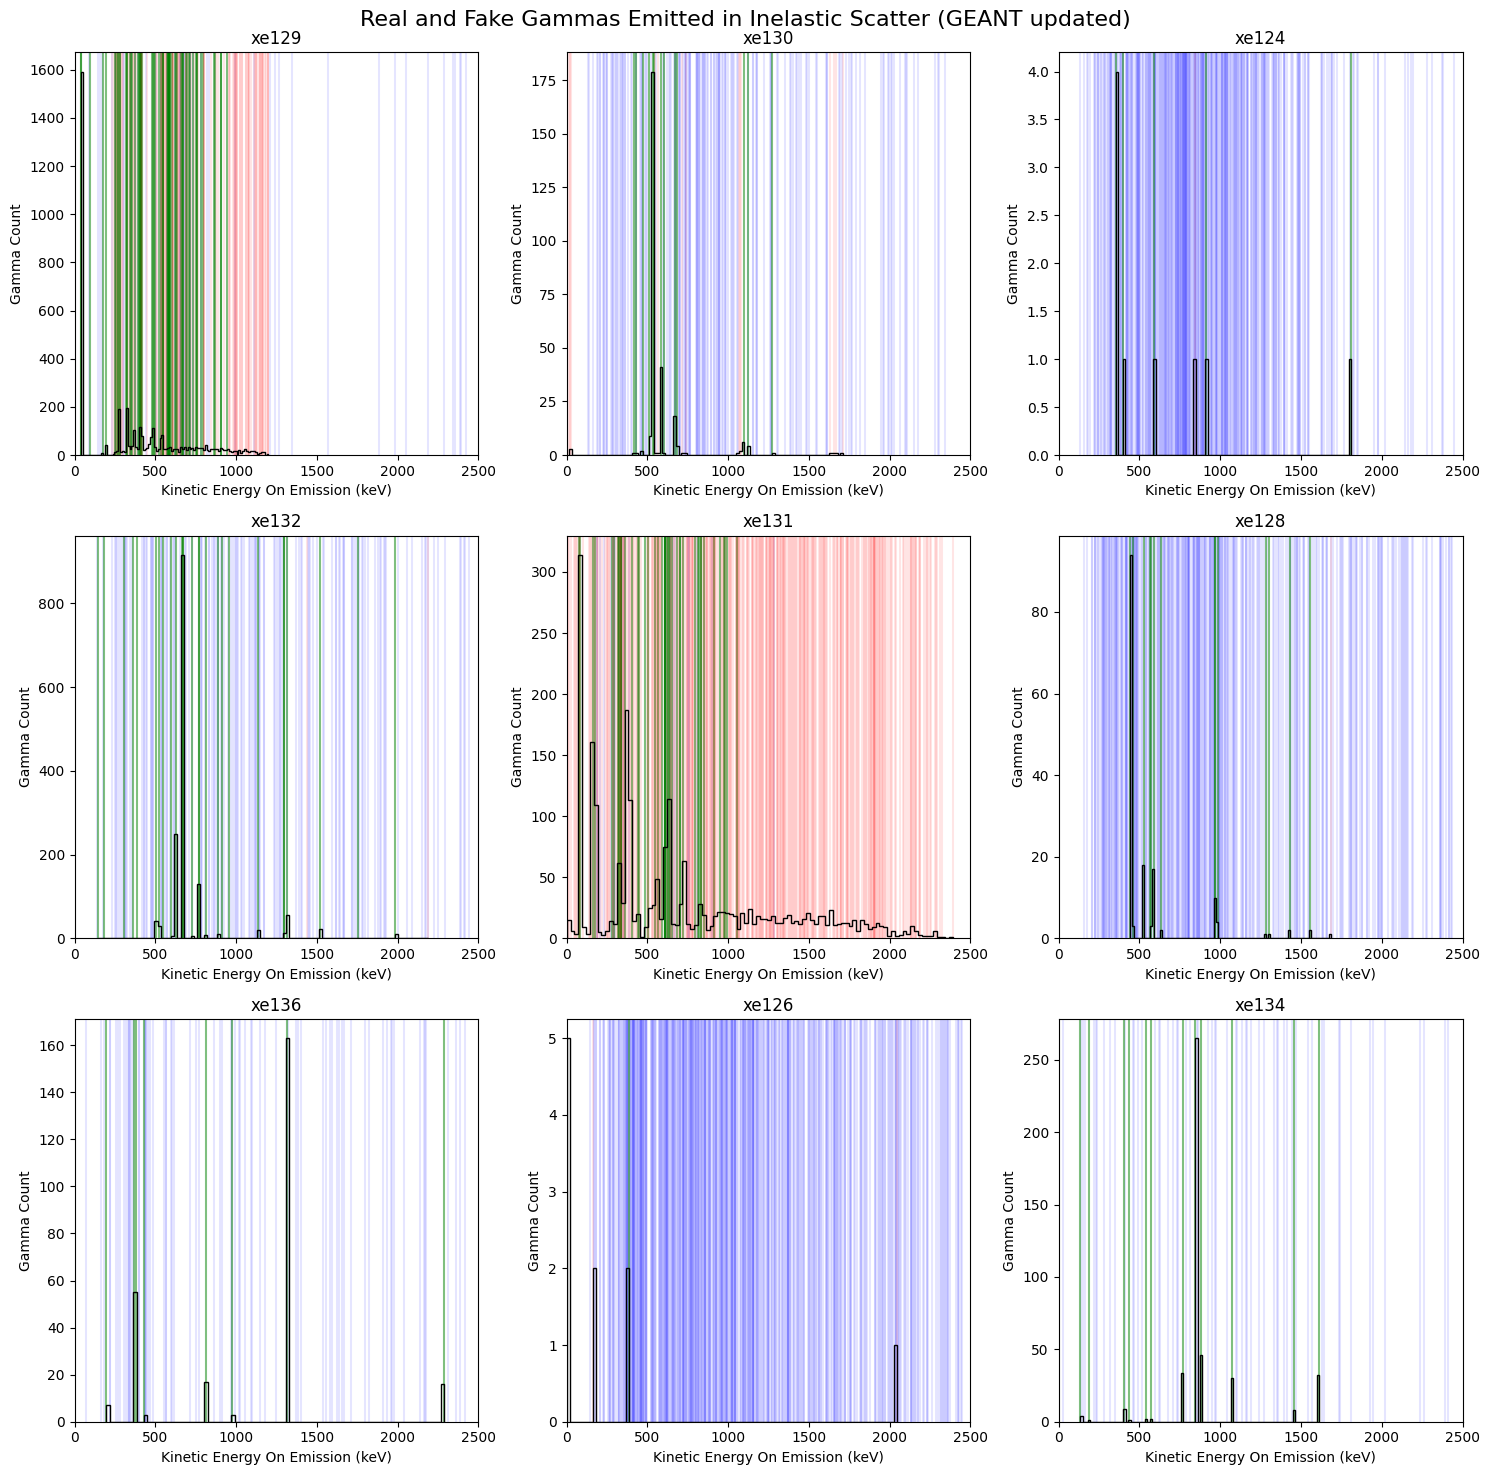

In [353]:
# Create a 3x3 grid of subplots
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Real and Fake Gammas Emitted in Inelastic Scatter (GEANT updated)', fontsize=16)

# Flatten the axes array for easy iteration
axes = axes.flatten()


for i, key in enumerate(list(gamma_data.keys())):
    
    sim_data_gammas_name = f"gammas_energies_{key}"
    sim_data_gammas = globals().get(sim_data_gammas_name)
  
    #Plot lines in each subplot 
    for line in gamma_data[key]['missing']:
        axes[i].axvline(line, color='blue', alpha=0.1) 
        
    for line in gamma_data[key]['real']:
        axes[i].axvline(line, color='green', alpha=0.5) 
        
    for line in gamma_data[key]['fake_th']: #outside ±1keV of real lines
        axes[i].axvline(line, color='red', alpha=0.1) 
    
    # Plot histograms in each subplot
    axes[i].hist(sim_data_gammas, 100, histtype='step', color='black')
    axes[i].set_title(key)
    
    axes[i].set_xlim(0, 2500)  # Set x-axis limits
    axes[i].set_ylim(0,)  # Set y-axis limits
    
    axes[i].set_xlabel('Kinetic Energy On Emission (keV)')  # Add x-axis label
    axes[i].set_ylabel('Gamma Count')  # Add y-axis label


    

    
# Adjust the layout
plt.tight_layout()
plt.show()

In [343]:
gamma_data['xe132']['fake_th']

[1442.0, 2187.0]

## Cross Section Comparison 

Compare ratio of neutron inelastic scatters, elastic scatters and capture to cross section prediction for 2.45MeV neutrons 

Only look at first step of primary neutron


In [356]:
#looking at first step 

c1_primary_inelastic_events = [] 
c1_primary_elastic_events = [] 
c1_primary_ncapture_events = [] 
n = 0

elastic_scatter_id = find_processes('hadElastic')
ncapture_id = find_processes('nCapture')

for i, i_evt in enumerate(events['header.eventId']):

    if events[i]['track.step.processesID'][0][0] == neutronInelasticId: 
            c1_primary_inelastic_events.append(i)

    if events[i]['track.step.processesID'][0][0] == elastic_scatter_id:
            c1_primary_elastic_events.append(i)

    if events[i]['track.step.processesID'][0][0] == ncapture_id:
            c1_primary_ncapture_events.append(i)
 

In [357]:
print('In the first step:')
print(f'Inelastic scatters {len(c1_primary_inelastic_events)}')
print(f'Elastic scatters {len(c1_primary_elastic_events)}')
print(f'Neutron captures {len(c1_primary_ncapture_events)}')


In the first step:
Inelastic scatters 1078
Elastic scatters 2201
Neutron captures 7


In [358]:
#look at which Xenon isotopes captured neutrons 

particles = []
for i_evt in c1_primary_ncapture_events:
    particles.append(np.array(events[i_evt]['track.particleNames'][events[i_evt]['track.particleCreatorProcesses'] == 'nCapture']))

isotopes = []
for particle_array in particles:
    for p in particle_array:
        if p.startswith('Xe'):
            isotopes.append(p)
            
isotopes, counts = np.unique(np.array(isotopes), return_counts=True)

print('Neutrons were captured to form these Xenon isotopes:')
for i in range(len(isotopes)):
    print(f'{isotopes[i]} {counts[i]} occurances') 

print()
print(f'Xenon atoms counted: {np.sum(counts)}') 

Neutrons were captured to form these Xenon isotopes:
Xe130 1 occurances
Xe132 2 occurances
Xe133 4 occurances

Xenon atoms counted: 7


In [359]:
#xenon data 
xe_isotopes = ['Xe124','Xe126', 'Xe128','Xe129','Xe130','Xe131','Xe132','Xe134','Xe136']
abundances = [0.09,0.09,1.92,26.44,4.08,21.18,26.89,10.44,8.87]

#cross sections each process for 2.45MeV neutrons
#from reading off ENDF interpolated plot estimation 

#elastic, inelastic, capture #unit barns 
xe124_cs = [3.11, 2.30, 0.129]
xe126_cs = [4.13, 1.34, 0.363]
xe128_cs = [4.16, 1.52, 0.105]
xe129_cs = [3.59, 1.87, 0.02]
xe130_cs = [3.55, 1.91, 0.0334]
xe131_cs = [3.79, 1.97, 0.012]
xe132_cs = [3.74, 1.74, 0.0089]
xe134_cs = [3.94, 1.66, 0.006]
xe136_cs = [4.20, 1.37, 0.00043]

cs = np.array([xe124_cs, xe126_cs, xe128_cs, xe129_cs, xe130_cs, xe131_cs, xe132_cs, xe134_cs, xe136_cs])


In [360]:
#weighted individual cross-sections
w = np.transpose(np.array([abundances]*3))

w_cs = w  * cs 
w_cs_nat_xenon = np.sum(w_cs, axis=0) 

In [361]:
w_cs_nat_xenon

array([377.2708   , 178.4771   ,   1.4708871])

In [362]:

print('Weighted Xenon Cross Section Ratios')
ratio = w_cs_nat_xenon/np.sum(w_cs_nat_xenon) 

print(f'Elastic: {ratio[0]}')
print(f'Inelastic: {ratio[1]}')
print(f'Capture: {ratio[2]}')

print('')

#ratio 
total = len(c1_primary_inelastic_events) + len(c1_primary_elastic_events) + len(c1_primary_ncapture_events)

print('Ratio of Each Process for Primary Neutron From Sim')
print(f'Elastic: {len(c1_primary_elastic_events)/total}')
print(f'Inelastic: {len(c1_primary_inelastic_events)/total}')
print(f'Capture: {len(c1_primary_ncapture_events)/total}')


Weighted Xenon Cross Section Ratios
Elastic: 0.6770604450784498
Inelastic: 0.32029986090180046
Capture: 0.002639694019749608

Ratio of Each Process for Primary Neutron From Sim
Elastic: 0.6698113207547169
Inelastic: 0.3280584297017651
Capture: 0.002130249543517955


Cross sections matching, reaction rates are correct for these neutrons 

## Inelastic Scatter Xenon De-excitation Gamma Emission Time

In [371]:
#check first index always the neutron 
for i in range(len(events[inelastic_events])):
    if events[inelastic_events]['track.particleNames'][i][0] != 'neutron':
        print('y')

In [372]:
#get time of inelastic scatter - just look at primary neutron first inelastic scatters 

event_inelastic_times = [] 

for i in inelastic_events:
    inelastic_time = events['track.step.times_ns'][i][0][-1] #final time step, track stops when inelastic scatters 
    event_inelastic_times.append(inelastic_time)


In [373]:
#get time of gamma emission 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i in inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i]['track.particleNames']):
     
        if particle == 'gamma' and events['track.particleCreatorProcesses'][i][i_particle] == 'neutronInelastic' and events['track.particleParentIDs'][i][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            gamma_times.append(events['track.step.times_ns'][i][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)

    

In [374]:
len(event_inelastic_times), len(event_gamma_times)

(3015, 3015)

In [375]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

In [376]:
len(emission_times)

3015

In [377]:
all_times = np.concatenate(emission_times)

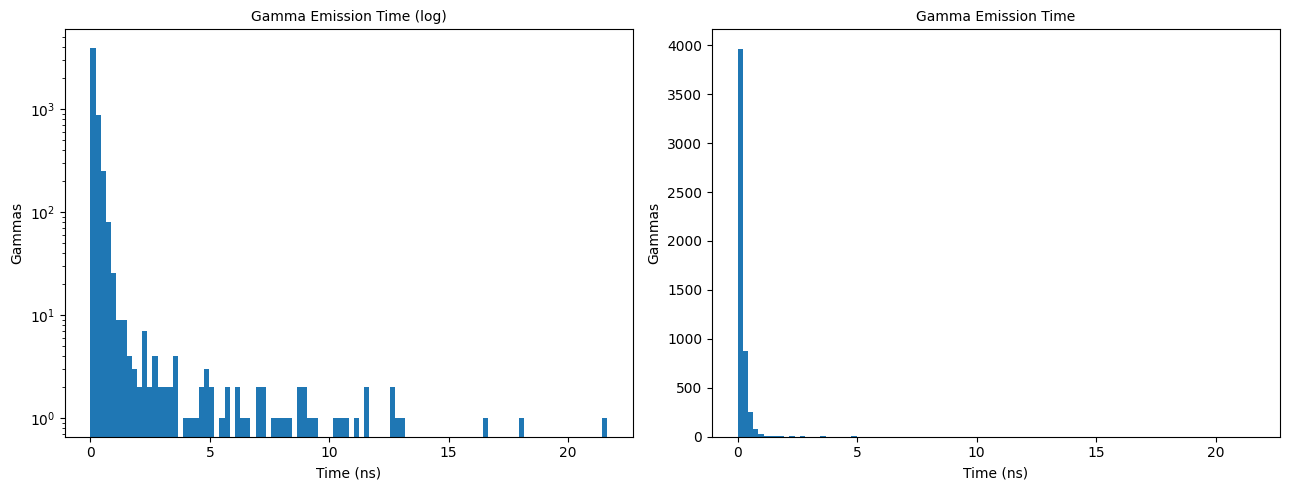

In [378]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(all_times, 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(all_times, 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('Gamma Emission Time', fontsize=10);

plt.tight_layout();

#### 40keV Gammas

In [395]:
#get time of gamma emission 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i in inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i]['track.particleNames'][:10]): #first scatter generally within first 10, speeds up a lot 
     
        if particle == 'gamma' and events['track.particleCreatorProcesses'][i][i_particle] == 'neutronInelastic' and events['track.particleParentIDs'][i][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            if round(events[i]['track.step.kinEnergies_keV'][i_particle][0], 1)==39.6:     
                gamma_times.append(events['track.step.times_ns'][i][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)

    

In [397]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

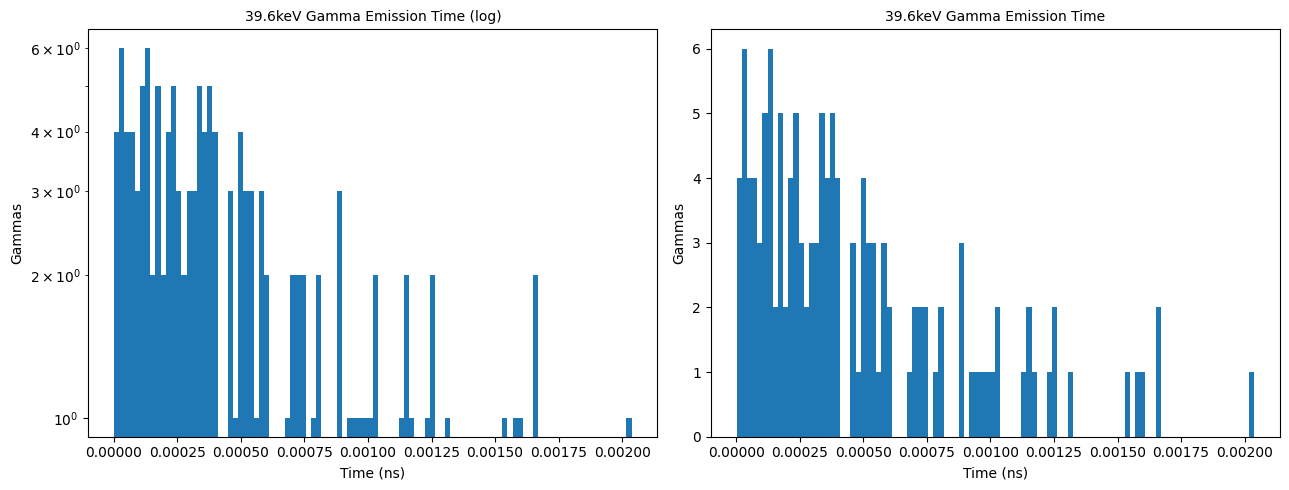

In [399]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('39.6keV Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('39.6keV Gamma Emission Time', fontsize=10);


plt.tight_layout();

Halflife of Xe129 40keV state is 0.97ns - not on the plots!

In [31]:
#plot what it should look like

t_half = 0.97 #ns 
t_life = t_half/np.log(2)
decay_rate = 1/t_life

t = np.linspace(0,10,100) #ns
pdf = decay_rate*(np.e**(-t*decay_rate))


Text(0.5, 0, 'time (ns)')

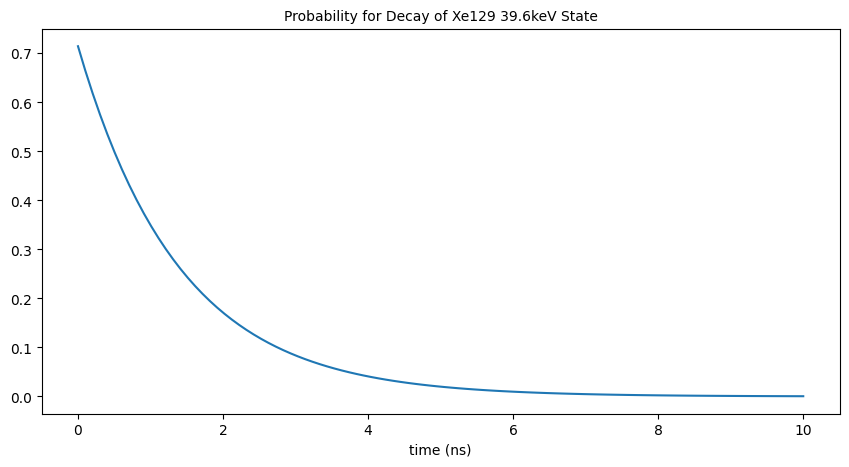

In [34]:
plt.figure(figsize=(35, 5));
plt.subplot(131);

plt.plot(t, pdf)

plt.title('Probability for Decay of Xe129 39.6keV State', fontsize=10)
plt.xlabel('time (ns)')


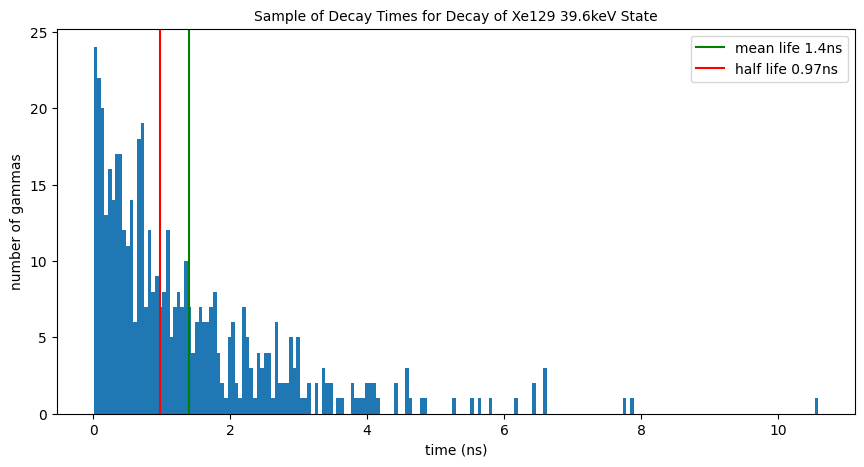

In [67]:
samples = np.random.exponential(t_life, 500)

plt.figure(figsize=(35, 5))
plt.subplot(131)
plt.hist(samples, 200)
plt.title('Sample of Decay Times for Decay of Xe129 39.6keV State', fontsize=10)
plt.ylabel('number of gammas')
plt.xlabel('time (ns)')




plt.axvline(t_life, color='green', label=f'mean life {np.round(t_life,2)}ns')
plt.axvline(t_half, color='red', label=f'half life {t_half}ns')
plt.legend()



Very different to the sim data, emission times are the same shape but are all too short 

#### Long-lived 11.9d state of Xe131 163.93keV

In [389]:
#get times of 164keV gammas 
event_gamma_times = [] #array of arrays, multiple gammas from single scatter 

for i in inelastic_events:
        
    gamma_times = []
    for i_particle, particle in enumerate(events[i]['track.particleNames'][:10]):
     
        if particle == 'gamma' and events[i]['track.particleCreatorProcesses'][i_particle] == 'neutronInelastic' and events[i]['track.particleParentIDs'][i_particle] == 1: #parent needs to be primary, primary has trackid 1 so parenttrackid is 1 for gammas 
            if round(events[i]['track.step.kinEnergies_keV'][i_particle][0], 1)==163.9:    
                gamma_times.append(events[i]['track.step.times_ns'][i_particle][0]) #time at first step
            
    event_gamma_times.append(gamma_times)


In [390]:
#get lifetime of excited state 
emission_times = [] #gamma emission times for each event in ns 
for i, event in enumerate(event_gamma_times):
    emission_time = np.array(event) - event_inelastic_times[i]
    emission_times.append(emission_time)

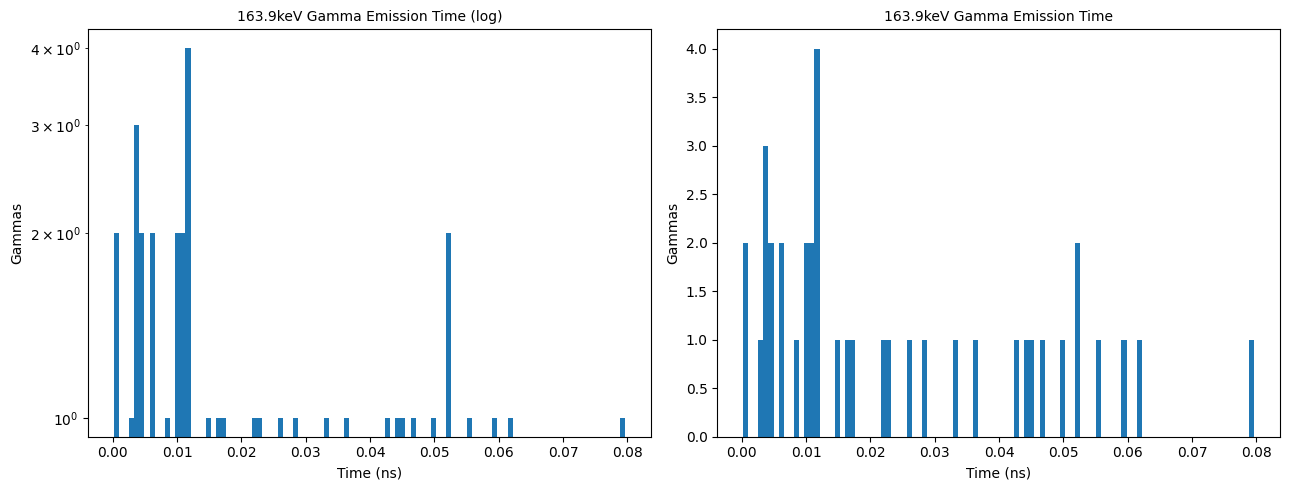

In [391]:
plt.figure(figsize=(13, 5));
plt.subplot(121);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('163.9keV Gamma Emission Time (log)', fontsize=10);
plt.yscale('log');

plt.subplot(122);
plt.hist(np.concatenate(emission_times), 100);
plt.ylabel('Gammas');
plt.xlabel(r'Time (ns)');
plt.title('163.9keV Gamma Emission Time', fontsize=10);


plt.tight_layout();

If these gammas do correspond to long-lived state then longer times missing

## Single/Multiple Scatters LZLAMA

Ran LZLAMA on energy only sims 

In [300]:
file_lzlama = '' #4000 

In [301]:
content = uproot.open(file_lzlama)
print(f'Trees inside file: {content.keys()}')

Trees inside file: ['Events;1', 'Scatters;1', 'RQMCTruth;1']


In [302]:
events_lzlama = content["Events"].arrays() 
scatters = content["Scatters"].arrays()  
rqmctruth = content["RQMCTruth"].arrays() 

In [303]:
print(f"Number of trigger events: {len(events_lzlama['eventHeader.eventID'])}")

Number of trigger events: 37485


Larger than neutrons reaching xenon, particles enter detector like gammas from inelastic scatter outside the volume 

In [304]:
n_ss, counts_ss = np.unique(scatters["ss.nSingleScatters"], return_counts=True)

In [305]:
print(f'Total number of events with single scatters: {counts_ss[1]}')

Total number of events with single scatters: 4062


In [306]:
n_ms, counts_ms = np.unique(scatters["ms.nMultipleScatters"], return_counts=True)

In [307]:
print(f'Total number of events with multiple scatters: {counts_ms[1]}')

Total number of events with multiple scatters: 19481


### Inelastic Events

Find percentage of inelastic scatters that are single and multiple 

In [308]:
a = events[inelastic_events]["header.eventId"]

In [309]:
a[:5]

<Array [21, 102, 106, 154, 198] type='5 * uint32'>

In [310]:
b = events_lzlama["eventHeader.eventID"]

In [311]:
result = set(a).issubset(set(b))
print(result)  

True


In [312]:
#just looking at 2.45MeV neutron events 
inelastic_events_lzlama = []
inelastic_events_ss = []
inelastic_events_ms = []

for evta in events[inelastic_events]["header.eventId"]:
    for i, evtb in enumerate(events_lzlama["eventHeader.eventID"]):
        if evta==evtb:
            inelastic_events_lzlama.append(i)
            if scatters[i]["ss.nSingleScatters"] == 1:
                inelastic_events_ss.append(evta)
            elif scatters[i]["ms.nMultipleScatters"] == 1:
                inelastic_events_ms.append(evta)
            
inelastic_ss = len(inelastic_events_ss)
inelastic_ms = len(inelastic_events_ms)

In [313]:
total = inelastic_ss+inelastic_ms

print('Percentage inelastic events')
print(f'Single scatter: {round(100*(inelastic_ss/total))}%')
print(f'Multiple scatter: {round(100*(inelastic_ms/total))}%')


Percentage inelastic events
Single scatter: 1%
Multiple scatter: 99%


Almost all multiple? - doesn't look right

In [170]:
total

844

## Clustering Energy Deposits to Find Single to Multi Scatter Ratio

Use baccarat deposits -> mctruth should be ok but might be unreliable 

In [314]:
#parameters
zres = 10 #mm -> distance between cluster members will be lower
xres = 30 #mm
yres = 30 #mm
energy_threshold = 5 #keV -> sum total energy of cluster if below undetectable 
timescale = 7 #µs -> time between cluster members will be lower 

In [315]:
def cluster_func(data): #data for 1 event 

    cluster = [] #holds cluster so can remove later 
    cluster_index = []
    unclustered_index = []

    #find max deposit 
    max_deposit = data['energyDep_keV'][0]
    max_i = 0

    for i_dep, dep in enumerate(data['energyDep_keV']):
        if dep>max_deposit:
            max_deposit=dep
            max_i = i_dep 

    max_time = data['time_ns'][max_i]
    max_x = data['positionX_mm'][max_i]
    max_y = data['positionY_mm'][max_i]
    max_z = data['positionZ_mm'][max_i]

    cluster.append(max_deposit)
    cluster_index.append(max_i)
    

    #loop through each deposit to get cluster 
    for i_dep, dep in enumerate(data['energyDep_keV']):

    
        #not max 
        if not dep == max_deposit:

            #check euclidean distance 
            x = abs(data['positionX_mm'][i_dep] - max_x)
            y = abs(data['positionY_mm'][i_dep] - max_y)
            z = abs(data['positionZ_mm'][i_dep] - max_z)
                    
            #check timescale 
            time_diff = abs(max_time-data['time_ns'][i_dep]) #max deposit not nessarily first 
            t = timescale*(0.01) #need to change to ns 
            
            #if  z<zres and time_diff<t:
            if z<zres and x<xres and y<yres and time_diff<t: #adding x and y 
                cluster.append(dep)
                cluster_index.append(i_dep)
                
            else: 
                unclustered_index.append(i_dep)
  
                    
                    
    return cluster, cluster_index, unclustered_index

    

In [316]:
#clustering 
events_clusters = {} 
events_clusters['eventID'] = events['header.eventId']
events_clusters_list = [] #list of lists for each event 
events_clusters_list_eth = [] #hold those above energy threshold 

#loop through events 
for i, evt in enumerate(events['header.eventId']):
    
    clusters = []
    clusters_eth = []
    
    #set up event data 
    event_data = {}
    event_data['eventID'] = events['header.eventId'][i]
    event_data['energyDep_keV'] = events['deposits.EnergyDeps_keV'][i]
    event_data['time_ns'] = events['deposits.times_ns'][i]
    event_data['positionX_mm'] = events['deposits.positions_x_mm'][i]
    event_data['positionY_mm'] = events['deposits.positions_y_mm'][i]
    event_data['positionZ_mm'] = events['deposits.positions_z_mm'][i]

    
    #loop over data until all clustered 
    empty=False
    while empty==False:
    
        #cluster 
        cluster, index, unclustered = cluster_func(event_data)
        clusters.append(cluster)
        
        #energy threshold check
        if np.sum(np.array(cluster)) > energy_threshold:
            clusters_eth.append(cluster)
        
        #remove if any deposits left 
        
        #unclustered index 
        event_data_update = {}
        event_data_update['energyDep_keV'] = event_data['energyDep_keV'][unclustered]
        event_data_update['time_ns'] = event_data['time_ns'][unclustered]
        event_data_update['positionX_mm'] = event_data['positionX_mm'][unclustered] 
        event_data_update['positionY_mm'] = event_data['positionY_mm'][unclustered] 
        event_data_update['positionZ_mm'] = event_data['positionZ_mm'][unclustered]       

        event_data=event_data_update

        if event_data['energyDep_keV'].tolist() == []:
            empty=True 
         
    events_clusters_list.append(clusters)
    events_clusters_list_eth.append(clusters_eth)
     
    

    
events_clusters['depositClusters_keV'] = events_clusters_list
events_clusters['depositClustersThreshold_keV'] = events_clusters_list_eth


In [317]:
#count clusters to get single/multiple scatter ratio 
ss = 0
ms = 0
none = 0
for clusters in events_clusters['depositClustersThreshold_keV']:
    if len(clusters) == 1:
        ss+=1
    elif len(clusters) > 1:
        ms+=1
    else:
        none+=1

In [318]:
ss, ms, none

(785, 8836, 64)

In [319]:
tot = ss+ms
print(f'Inelastic events scattering using clustering of deposits above energy threshold {energy_threshold}keV')
print(f'Single scatter {np.round(100*(ss/tot))}%')
print(f'Multiple scatter {np.round(100*(ms/tot))}%')

Inelastic events scattering using clustering of deposits above energy threshold 5keV
Single scatter 8.0%
Multiple scatter 92.0%


Looks better than lzlama scatters ratio? But still high? -> find what it should be 

Chnages a lot when using x and y res too

In [815]:
events_clusters['depositClustersThreshold_keV'][3]

[[118.41965534544616, 0.69091, 6.242676149491742, 93.14521356808883],
 [109.53355049255913,
  0.06778,
  5.103900000000005,
  5.416899999999999,
  0.39604908702694985,
  23.639150912973047,
  3.9430865165953257,
  28.48174304313823,
  0.39969576646931254,
  46.658805533339574],
 [105.4649643794653,
  0.69091,
  5.103900000000005,
  1.1219999999999999,
  0.12110881309473205,
  28.208991186905266,
  3.012364372275583,
  30.913750897868532,
  5.39427725520212,
  97.48669407883698,
  88.54436402585904,
  52.19326245423299,
  0.2585891953164435,
  30.704481207242413],
 [44.72265188815072],
 [39.71109424310271],
 [38.55445708904881],
 [18.233335780678317],
 [9.776192920980975],
 [6.947118061361834]]

### Clustering using only deposits with certain particle id

In [788]:
#modify data to only hold neutron or xenon deposits -> use pid 

deposit_data = {}
for field in events.fields:
    if (field.split('.')[0] == 'deposits'):
        deposit_data[field.split('.')[1]] = events[field]

In [789]:
deposit_data

{'volumeNames': <Array [['LiquidXenonTarget', ...], ..., [...]] type='1949 * var * string'>,
 'pids': <Array [[1000541310, 22, 22, ..., 11, 11, 11], ...] type='1949 * var * int32'>,
 'trackIds': <Array [[3, 4, 73, 74, ..., 95, 95, 94, 94], ...] type='1949 * var * uint32'>,
 'parentTrackIds': <Array [[1, 1, 4, 73, 73, ..., 75, 75, 76, 76], ...] type='1949 * var * uint32'>,
 'EnergyDeps_keV': <Array [[57.7, 5.1, 1.12, ..., 0.0555, 3.35], ...] type='1949 * var * float64'>,
 'times_ns': <Array [[167, 167, 167, ..., 167, 167, 167], ...] type='1949 * var * float64'>,
 'positions_x_mm': <Array [[-676, -675, -675, ..., -675, -675], ...] type='1949 * var * float64'>,
 'positions_y_mm': <Array [[66.4, 65.2, 65.2, ..., 65.1, 65.1], ...] type='1949 * var * float64'>,
 'positions_z_mm': <Array [[1.36e+03, 1.36e+03, ..., 1.36e+03], ...] type='1949 * var * float64'>,
 'stepLength_mm': <Array [[0.00047, 2.55, ..., 0.000339], ..., [...]] type='1949 * var * float64'>,
 'trackCumulativeLength_mm': <Array

In [816]:
#100054***0 is xenon NR, 11 is electron, neutron 2112, gamma 22
#create a mask to apply to deposit data 
masks = []
for i_evt in range(len(deposit_data['volumeNames'])):
    mask = []
    
    for i, pid in enumerate(deposit_data["pids"][i_evt]):
        
        string = str(pid)
        #if pid == 2112 or string.startswith('100054'):
        if pid == 2112 or string.startswith('100054') or pid==22: #adding gamma rays 
            mask.append(i)
            
    masks.append(mask)  

In [817]:
#get new deposit data using masks
deposit_data_neutron_xe = {}

for field in list(deposit_data.keys()):
    
    new_field_data = []
    
    for i in range(len(deposit_data[field])):
        current_mask = masks[i]
        new_field_data.append(deposit_data[field][i][current_mask])
    
    deposit_data_neutron_xe[field] = new_field_data


In [818]:
#cluster using the neutron and xenon deposit data 

#clustering 
events_clusters = {} 
events_clusters['eventID'] = events['header.eventId']
events_clusters_list = [] #list of lists for each event 
events_clusters_list_eth = [] #hold those above energy threshold 

#loop through events 
for i, evt in enumerate(events['header.eventId']):

    
    clusters = []
    clusters_eth = []
    
    #set up event data 
    event_data = {}
    event_data['eventID'] = events['header.eventId'][i]
    event_data['energyDep_keV'] = deposit_data_neutron_xe['EnergyDeps_keV'][i]
    event_data['time_ns'] = deposit_data_neutron_xe['times_ns'][i]
    event_data['positionX_mm'] = deposit_data_neutron_xe['positions_x_mm'][i]
    event_data['positionY_mm'] = deposit_data_neutron_xe['positions_y_mm'][i]
    event_data['positionZ_mm'] = deposit_data_neutron_xe['positions_z_mm'][i]

    
    #loop over data until all clustered 
    empty=False
    while empty==False:
    
        #cluster 
        cluster, index, unclustered = cluster_func(event_data)
        clusters.append(cluster)
        
        #energy threshold check
        if np.sum(np.array(cluster)) > energy_threshold:
            clusters_eth.append(cluster)
        
        #remove if any deposits left 
        
        #unclustered index 
        event_data_update = {}
        event_data_update['energyDep_keV'] = event_data['energyDep_keV'][unclustered]
        event_data_update['time_ns'] = event_data['time_ns'][unclustered]
        event_data_update['positionX_mm'] = event_data['positionX_mm'][unclustered] 
        event_data_update['positionY_mm'] = event_data['positionY_mm'][unclustered] 
        event_data_update['positionZ_mm'] = event_data['positionZ_mm'][unclustered]       

        event_data=event_data_update

        if event_data['energyDep_keV'].tolist() == []:
            empty=True 
         
    events_clusters_list.append(clusters)
    events_clusters_list_eth.append(clusters_eth)
     
    

    
events_clusters['depositClusters_keV'] = events_clusters_list
events_clusters['depositClustersThreshold_keV'] = events_clusters_list_eth


In [819]:
events_clusters['depositClustersThreshold_keV'][:5]

[[[57.66598312766291,
   5.103900000000005,
   1.1219999999999999,
   0.67752,
   0.9266000000000065,
   0.9265599999999999]],
 [[41.20227265229914, 0.9894700000000001],
  [13.748222976573743],
  [8.002633228898048],
  [6.087494431994855],
  [5.7013000000000025, 4.774699999999999],
  [5.416899999999999, 4.774699999999999, 4.774700000000003, 0.67752],
  [5.103900000000005, 0.01096, 0.69091],
  [5.103899999999999,
   0.02361,
   0.9895000000000043,
   0.16069,
   4.774700000000003,
   4.774699999999999,
   0.67752,
   0.67752,
   2.2595083282794803,
   0.9265599999999999,
   4.774700000000003,
   1.1219999999999999],
  [4.774699999999999, 0.9894700000000001]],
 [[45.909180626040325, 0.67752],
  [34.556000000000004, 0.06984],
  [18.16128428617958],
  [6.121261307271197]],
 [[44.72265188815072],
  [39.71109424310271],
  [38.55445708904881],
  [18.233335780678317],
  [9.776192920980975],
  [6.947118061361834],
  [5.416899999999999, 0.06778, 5.103900000000005],
  [5.103900000000005, 0.69091,

Makes more clusters when gammas are included

In [820]:
#count clusters to get single/multiple scatter ratio 
ss = 0
ms = 0
none = 0
#for clusters in events_clusters['depositClusters_keV']:
for clusters in events_clusters['depositClustersThreshold_keV']:
    if len(clusters) == 1:
        ss+=1
    elif len(clusters) > 1:
        ms+=1
    else:
        none+=1

In [821]:
ss, ms, none

(185, 1744, 20)

In [822]:
tot = ss+ms
print(f'Inelastic events scattering using clustering of neutron and xenon deposits above energy threshold {energy_threshold}keV')
print(f'Single scatter {np.round(100*(ss/tot))}%')
print(f'Multiple scatter {np.round(100*(ms/tot))}%')

Inelastic events scattering using clustering of neutron and xenon deposits above energy threshold 5keV
Single scatter 10.0%
Multiple scatter 90.0%


Neutrons and xenon - not sure if this is working correctly clusters mostly 1 member, quite different ratio 

Including gammas - causes some clusters to form and the ratio similar to that for all particles

### Clustering using parent track id=1 (primary neutron) deposits 

In [654]:
#alternate masks using parentid=1 for primary neutron 
#create a mask to apply to deposit data 

masks_parent = []
for i_evt in range(len(deposit_data['volumeNames'])):
    mask = []
    
    for i, pid in enumerate(deposit_data["parentTrackIds"][i_evt]):
        
        if pid == 1:
            mask.append(i)
            
    masks_parent.append(mask)

In [655]:
deposit_data_parent1 = {}

for field in list(deposit_data.keys()):
    
    new_field_data = []
    
    for i in range(len(deposit_data[field])):
        if i==1511: #this was empty so don't add 
            continue 
            
        current_mask = masks_parent[i]
        new_field_data.append(deposit_data[field][i][current_mask]) 
        
        
    deposit_data_parent1[field] = new_field_data


In [656]:
#cluster using the neutron and xenon deposit data 

#clustering 
events_clusters = {} 
events_clusters_list = [] #list of lists for each event 
events_clusters_list_eth = [] #hold those above energy threshold 

#loop through events 
for i, evt in enumerate(deposit_data_parent1['EnergyDeps_keV']):

    
    clusters = []
    clusters_eth = []
    
    #set up event data 
    event_data = {}
    event_data['energyDep_keV'] = deposit_data_parent1['EnergyDeps_keV'][i]
    event_data['time_ns'] = deposit_data_parent1['times_ns'][i]
    event_data['positionX_mm'] = deposit_data_parent1['positions_x_mm'][i]
    event_data['positionY_mm'] = deposit_data_parent1['positions_y_mm'][i]
    event_data['positionZ_mm'] = deposit_data_parent1['positions_z_mm'][i]

    
    #loop over data until all clustered 
    empty=False
    while empty==False:
    
        #cluster 
        cluster, index, unclustered = cluster_func(event_data)
        clusters.append(cluster)
        
        #energy threshold check
        if np.sum(np.array(cluster)) > energy_threshold:
            clusters_eth.append(cluster)
        
        #remove if any deposits left 
        
        #unclustered index 
        event_data_update = {}
        event_data_update['energyDep_keV'] = event_data['energyDep_keV'][unclustered]
        event_data_update['time_ns'] = event_data['time_ns'][unclustered]
        event_data_update['positionX_mm'] = event_data['positionX_mm'][unclustered] 
        event_data_update['positionY_mm'] = event_data['positionY_mm'][unclustered] 
        event_data_update['positionZ_mm'] = event_data['positionZ_mm'][unclustered]       

        event_data=event_data_update

        if event_data['energyDep_keV'].tolist() == []:
            empty=True 
         
    events_clusters_list.append(clusters)
    events_clusters_list_eth.append(clusters_eth)
     
    

    
events_clusters['depositClusters_keV'] = events_clusters_list
events_clusters['depositClustersThreshold_keV'] = events_clusters_list_eth


In [657]:
events_clusters['depositClustersThreshold_keV'][:10]

[[[57.66598312766291, 5.103900000000005]],
 [[41.20227265229914, 0.9894700000000001], [13.748222976573743]],
 [[45.909180626040325, 0.67752],
  [34.556000000000004, 0.06984],
  [18.16128428617958],
  [6.121261307271197]],
 [[44.72265188815072], [39.71109424310271], [5.103900000000005, 0.69091]],
 [[72.57313406444155], [13.780224529909901]],
 [[15.462813462363556]],
 [[36.94642068876419]],
 [[34.556000000000004], [17.863983099232428]],
 [[58.48804353445303],
  [34.556000000000004],
  [15.009627444669604],
  [9.0618565591285, 0.06778, 0.01235, 0.9265599999999999],
  [4.774700000000003, 4.774699999999999, 0.67752]],
 [[16.90286742814351],
  [13.22741009062156],
  [12.885358912171796,
   4.774700000000003,
   0.9265599999999999,
   0.06984,
   5.103900000000005],
  [10.401407766039483],
  [5.103900000000005]]]

This data is making some clusters, but still a lot of single 

In [658]:
#count clusters to get single/multiple scatter ratio 
ss = 0
ms = 0
none = 0
#for clusters in events_clusters['depositClusters_keV']:
for clusters in events_clusters['depositClustersThreshold_keV']:
    if len(clusters) == 1:
        ss+=1
    elif len(clusters) > 1:
        ms+=1C
    else:
        none+=1

In [659]:
ss, ms, none

(535, 1378, 35)

In [807]:
tot = ss+ms
print(f'Inelastic events scattering using clustering of parentid=1 deposits above energy threshold {energy_threshold}keV')
print(f'Single scatter {np.round(100*(ss/tot))}%')
print(f'Multiple scatter {np.round(100*(ms/tot))}%')

Inelastic events scattering using clustering of parentid=1 deposits above energy threshold 5keV
Single scatter 25.0%
Multiple scatter 75.0%


Not taking into account that track changes after primary neutron inelastic scatters, maybe miscounting -> try find all trackids for the neutron and sort data using that otherwise i don't think accurate

In [ ]:
#plot clusters?

## Investigate Metastable States

Know timing of 164keV Xe131 is wrong 

In [402]:
#look at which Xenon isotopes in sim - any metastable ? 

particles = []
for i_evt, eventid in enumerate(events["header.eventId"]):
    #particles.append(np.array(events[i_evt]['track.particleIDs']))
    particles.append(np.array(events[i_evt]['track.particleNames']))
    #particles.append(np.array(events[i_evt]['track.particleIDs'][events[i_evt]['track.particleCreatorProcesses']=='neutronInelastic']))
    

isotopes = []
for particle_array in particles:
    for p in particle_array:
        p_str = str(p)
        #if p_str.startswith('100054'):
        if p_str.startswith('Xe'):
        
            isotopes.append(p)
            
isotopes, counts = np.unique(np.array(isotopes), return_counts=True)

print('Xenon isotopes:')
for i in range(len(isotopes)):
    print(f'{isotopes[i]} {counts[i]} occurances') 

    

Xenon isotopes:
Xe124 28 occurances
Xe125 5 occurances
Xe126 24 occurances
Xe127 3 occurances
Xe128 691 occurances
Xe129 9609 occurances
Xe130 2077 occurances
Xe131 6634 occurances
Xe132 9590 occurances
Xe133 62 occurances
Xe134 3581 occurances
Xe135 15 occurances
Xe136 3076 occurances


Not seeing any metastable states - geant4 just treating as another level


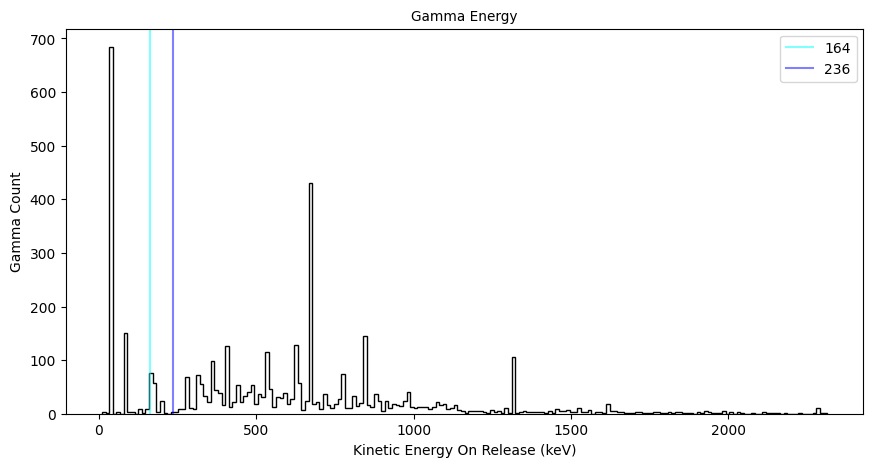

In [403]:
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 200, histtype='step', color='black')

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));


plt.axvline(164, color='cyan', alpha=0.5, label='164')
plt.axvline(236, color='blue', alpha=0.5, label='236')
plt.legend()

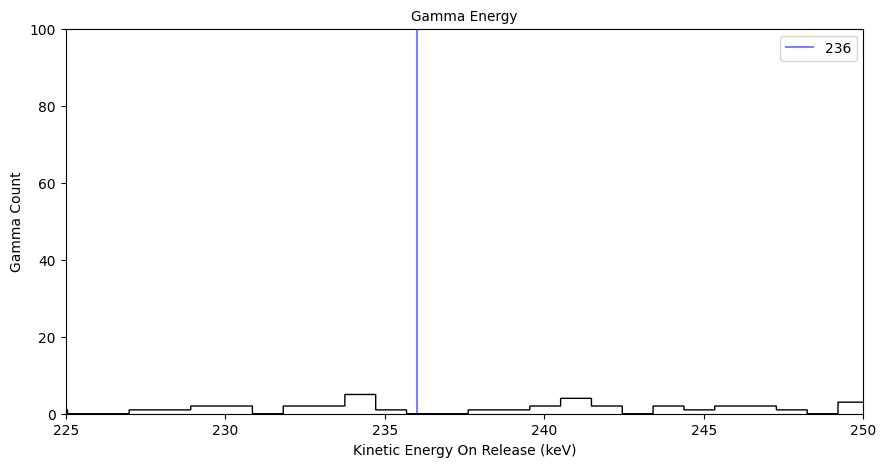

In [288]:
#129mXe 236keV
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(225, 250)
plt.ylim(0, 100)




plt.axvline(236, color='blue', alpha=0.5, label='236')
plt.legend()


Don't see 236keV in sim! 40+196keV lines 

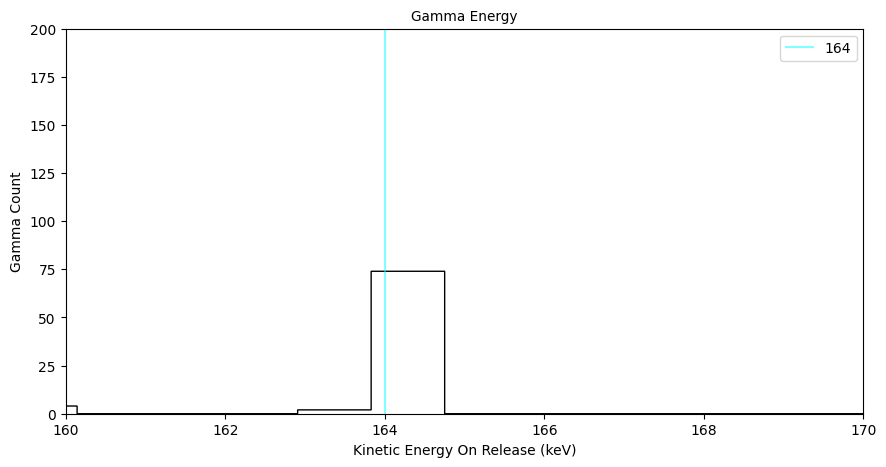

In [404]:
#129mXe 236keV
plt.figure(figsize=(35, 5));
plt.subplot(131);
plt.hist(gammas_energy, 2500, histtype='step', color='black') #1keV bins 

plt.xlabel('Kinetic Energy On Release (keV)')
plt.ylabel('Gamma Count')
plt.title('Gamma Energy', fontsize=(9.8));
plt.xlim(160, 170)
plt.ylim(0, 200)




plt.axvline(164, color='cyan', alpha=0.5, label='164')
plt.legend()


Metastable states aren't simulated properly -> GEANT4 issue 

Could electrons be emitted from xe and no gamma? or smaller gamma and an electron - how to check?

In [367]:
#check if any electrons have neutronInelastic or radioactive decay?
rdid = find_processes('RadioactiveDecay')

for i_evt, eventid in enumerate(events[inelastic_events][single_inelastic_scatter]["header.eventId"]):
    
    for i_par, particle in enumerate(events[i_evt]['track.particleNames']):
        if particle=='electron' and events[i_evt]['track.particleParentIDs'][i_par]==2:
            print('y')
            


## Energy Conservation

Look at neutron energy before and after, compare to gammas and xenon kinetic 

In [417]:
#find the single inelastic scatter events for easier matching 
single_inelastic_scatter = []

for x in range(len(events[inelastic_events]["track.particleNames"])):
    
    counter = 0
    for n in events[inelastic_events]["track.particleNames"][x]:
        if n.startswith('Xe'):
            counter+=1
          
    #only single inelastic scatters events
    if counter==1:
        single_inelastic_scatter.append(x)
    


In [418]:
single_inelastic_scatter_events = events[inelastic_events][single_inelastic_scatter] 

In [419]:
#for event index 0 
event_current = single_inelastic_scatter_events[0]

#neutron energy before and after  
n1 = event_current["track.step.kinEnergies_keV"][0][-1] #loses a small bit on energy before inelastic?? should i use 0 or -1?
n2 = event_current["track.step.kinEnergies_keV"][1][0] 

#xenon recoil energy 
xe = event_current["track.step.kinEnergies_keV"][2][0]

#gamma energies 
gamma_tot = 0 
for i, x in enumerate(event_current["track.particleNames"]):
    if x=='gamma' and event_current["track.particleCreatorProcesses"][i]=='neutronInelastic':
        gamma_tot+=event_current["track.step.kinEnergies_keV"][i][0]
        
        print(event_current["track.step.kinEnergies_keV"][i][0])

1041.5394286173976
1041.5394286173976


In [420]:
print(f'Before {n1}keV')
print(f'After {n2+xe+gamma_tot}keV')


Before 2450.0keV
After 2450.0000000069504keV


In [434]:
#check neutrons always index 0, 1 and xenon 2 
for i in range(len(single_inelastic_scatter_events)):
    event_current = single_inelastic_scatter_events[i]
    if not event_current["track.particleNames"][0] == 'neutron' and event_current["track.particleNames"][1] == 'neutron':
        print('false 1')
     
remove = []
for i in range(len(single_inelastic_scatter_events)):
    event_current = single_inelastic_scatter_events[i]
    if not event_current["track.particleNames"][2].startswith('Xe'):
        print('false 2')
        print(i)
        remove.append(i)
        

In [428]:
#remove false events 
single_inelastic_scatter_events_update = []
for i in range(len(single_inelastic_scatter_events)):
    if i in remove:
        print(i)
    else:
        single_inelastic_scatter_events_update.append(single_inelastic_scatter_events[i])
    
single_inelastic_scatter_events = single_inelastic_scatter_events_update

5
7
34
36
37
38
48
51
58
62
66
67
76
77


In [429]:
#loop over all single scatters to get stats 
conserved_energy = 0
conserved_energy_thresh = 0
not_conserved = []
counter=0
for i_evt in range(len(single_inelastic_scatter_events)):
    counter+=1
    
    event_current = single_inelastic_scatter_events[i_evt]
    
    n1 = event_current["track.step.kinEnergies_keV"][0][-1] #some lose a small bit on energy meaning 0 and -1 different
    n2 = event_current["track.step.kinEnergies_keV"][1][0]

    xe = event_current["track.step.kinEnergies_keV"][2][0]

    gamma_tot = 0 
    for i, x in enumerate(event_current["track.particleNames"]):
        if x=='gamma' and event_current["track.particleCreatorProcesses"][i]=='neutronInelastic' and event_current["track.particleParentIDs"][i]==1:
            gamma_tot+=event_current["track.step.kinEnergies_keV"][i][0]
            

    #check if conserved 
    num = 0 #how much rounding 
    if round(n1, num)==round(n2+xe+gamma_tot, num):
        conserved_energy+=1
        
    elif abs(round(n1, num) - round(n2+xe+gamma_tot, num)) > 1: #difference greater than 1keV
        print(i_evt, round(n1, num), round(n2+xe+gamma_tot, num))
        not_conserved.append(i_evt)
        
    else:
        conserved_energy_thresh+=1 

            
            
print('')    
print(f'Energy conserved to {num} decimal places in {conserved_energy}/{len(single_inelastic_scatter_events)} events')
print(f'Energy conserved ±1keV {conserved_energy+conserved_energy_thresh}/{len(single_inelastic_scatter_events)} events')
print(f'For the events where energy was not conserved {len(not_conserved)} events lost or gained greater than 1keV')




Energy conserved to 0 decimal places in 62/69 events
Energy conserved ±1keV 69/69 events
For the events where energy was not conserved 0 events lost or gained greater than 1keV


In [435]:
np.round( 100 * ( (conserved_energy) /len(single_inelastic_scatter_events)) )

90.0

In [430]:
np.round( 100 * ( (conserved_energy+conserved_energy_thresh) /len(single_inelastic_scatter_events)) )

100.0

Energy conserved

In [432]:
event_current = single_inelastic_scatter_events[not_conserved][0]
list(event_current["track.particleNames"][:8]), list(event_current["track.particleTrackIDs"][:8]), list(event_current["track.particleParentIDs"][:8]), list(event_current["track.particleCreatorProcesses"][:8])

TypeError: list indices must be integers or slices, not list

In [431]:
#check what's going on in non-conserved events 

event_current = single_inelastic_scatter_events[not_conserved][0]

#neutron energy before and after  
n1 = event_current["track.step.kinEnergies_keV"][0][-1] #loses a small bit on energy before inelastic?? should i use 0 or -1?
n2 = event_current["track.step.kinEnergies_keV"][1][0] 

#xenon recoil energy 
xe = event_current["track.step.kinEnergies_keV"][2][0]

#gamma energies 
gamma_tot = 0 
list_gammas = []
for i, x in enumerate(event_current["track.particleNames"]):
    if x=='gamma' and event_current["track.particleCreatorProcesses"][i]=='neutronInelastic' and event_current["track.particleParentIDs"][i]==1: #add parentparticle and see if difference 
        gamma_tot+=event_current["track.step.kinEnergies_keV"][i][0]
        
        list_gammas.append(event_current["track.step.kinEnergies_keV"][i][0])
        
        print(event_current["track.step.kinEnergies_keV"][i][0])

TypeError: list indices must be integers or slices, not list